In [1]:
import pandas as pd
from pandas import concat
import statsmodels.api as sm

from sklearn import metrics
from sklearn import preprocessing as prep
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sms
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pmdarima as pm
import pandas_datareader as web
from arch import  arch_model
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.utils import check_array
def MAPE(Y_test, preds): 
    Y_test, preds = np.array(Y_test), np.array(preds)
    return np.mean(np.abs((Y_test - preds) / Y_test)) * 100

In [3]:
stock = web.get_data_yahoo("T",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=860.050, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=904.877, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=896.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=897.290, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=902.879, Time=0.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=896.049, Time=0.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=877.466, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=855.066, Time=1.30 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=859.919, Time=0.64 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=854.524, Time=1.31 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=861.776, Time=0.98 sec
 ARIMA(6,1,3)(0,0,0)[0] intercept   : AIC=854.514, Time=1.85 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=845.717, Time=1.11 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=852.162, Time=0.62 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=861.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4629800914543.7295
Iteration:      2,   Func. Count:     14,   Neg. LLF: 442763553.2230431
Iteration:      3,   Func. Count:     20,   Neg. LLF: 48893687116.930885
Iteration:      4,   Func. Count:     28,   Neg. LLF: 40369.07015105955
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8412.211172056592
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1439.5371093776394
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1215.4111059167672
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1195.210257287808
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1147.8188434093784
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1224.3986285743908
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1190.859110702801
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1184.925165157681
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1153.9458992049324
Iteration:     14,   Func. Count:     88,   Neg. LLF: 118

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      3,   Func. Count:     20,   Neg. LLF: 434330560286.7936
Iteration:      4,   Func. Count:     28,   Neg. LLF: 5132.73837834573
Iteration:      5,   Func. Count:     34,   Neg. LLF: 13182.79310790344
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1912.4612250454984
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1225.415706005972
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1205.2187939459586
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1153.3254210933878
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1234.9352926726258
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1200.9536188369982
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1195.0942680028652
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1154.551419518713
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1194.7283324427494
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1113.8703802181435
Iteration:     16,   Func. Count:     99,   Neg. LLF: 111

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     23,   Func. Count:    134,   Neg. LLF: 1115.9169344432694
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1115.9169344737606
            Iterations: 23
            Function evaluations: 134
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5202410676321.597
Iteration:      2,   Func. Count:     14,   Neg. LLF: 426990369.6106656
Iteration:      3,   Func. Count:     20,   Neg. LLF: 465896927287.9967
Iteration:      4,   Func. Count:     28,   Neg. LLF: 23305.9527154461
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8767.341505571563
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1585.579914263794
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1233.7944857550758
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1212.3631185147838
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1156.7973467331456
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1236.9482097

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     10,   Func. Count:     64,   Neg. LLF: 1227.3151400925042
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1205.8487871264072
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1202.919324879168
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1160.2186265672362
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1203.7400342778453
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1120.9127644561622
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1120.444770021265
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1120.425294516705
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1120.0974616680837
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1120.036046113486
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1120.035763555346
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1120.035761752745
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1120.0357617368616
Optimization terminated successfully    (Exit mode 0)
   

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 421262346.8542736
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3720425240.16899
Iteration:      4,   Func. Count:     28,   Neg. LLF: 33883.00660128213
Iteration:      5,   Func. Count:     34,   Neg. LLF: 28166.16610040708
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1436.5046401798882
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1241.7205061529949
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1219.7755556471118
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1160.7636265737515
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1227.79222352458
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1210.17459498855
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1207.2125186766957
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1163.601415945486
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1207.658347853666
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1124.979

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     19,   Func. Count:    114,   Neg. LLF: 1126.466452570264
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1126.459827241858
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1126.4593239582337
Iteration:     22,   Func. Count:    128,   Neg. LLF: 1126.4593239580017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1126.4593239582337
            Iterations: 22
            Function evaluations: 128
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 623133461461.188
Iteration:      2,   Func. Count:     14,   Neg. LLF: 415176936.96628004
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2908285032.0598936
Iteration:      4,   Func. Count:     28,   Neg. LLF: 19816.46029588514
Iteration:      5,   Func. Count:     34,   Neg. LLF: 34160.82250940632
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1418.484374907065
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1244.4529246

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      9,   Func. Count:     58,   Neg. LLF: 1167.9009710182138
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1236.6467963921832
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1224.2582024833473
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1220.548285238406
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1170.1007644382848
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1211.4139815122396
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1134.3250046225899
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1134.2622477877046
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1133.4917514829017
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1133.1259938926605
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1132.9995215916824
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1132.9832411079747
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1132.9819058350645
Iteration:     22,   Func. Count:    130,   Neg. LLF

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30499854897.204147
Iteration:      2,   Func. Count:     14,   Neg. LLF: 418388709.71294236
Iteration:      3,   Func. Count:     20,   Neg. LLF: 10831002513.445438
Iteration:      4,   Func. Count:     28,   Neg. LLF: 215780.12685506142
Iteration:      5,   Func. Count:     34,   Neg. LLF: 222167.24873615833
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1494.3565566640243
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1261.1270984021112
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1241.1028311566033
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1175.487959354719
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1243.349712725063
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1232.8743082810784
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1228.9831410475324
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1178.8535072608177
Iteration:     14,   Func. Count:     88,   Neg. LLF:

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     13,   Func. Count:     82,   Neg. LLF: 1184.3171297967579
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1193.6294204961669
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1147.9188332296217
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1147.7458563604227
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1147.0955017096917
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1146.7624947763375
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1146.6556678761037
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1146.6452254036894
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1146.6445784178663
Iteration:     22,   Func. Count:    130,   Neg. LLF: 1146.644576415981
Iteration:     23,   Func. Count:    134,   Neg. LLF: 1146.6445763983993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1146.644576415981
            Iterations: 23
            Function evaluations: 134
            Gradient eval

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 419604674.51609343
Iteration:      3,   Func. Count:     20,   Neg. LLF: 19471284047.486053
Iteration:      4,   Func. Count:     28,   Neg. LLF: 4728.751488992964
Iteration:      5,   Func. Count:     34,   Neg. LLF: 14882.605798343857
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.6314857214943
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1269.4300251703173
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1255.4801228325873
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1188.5096116974707
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1255.3047104394411
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1248.927623869012
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1245.293538422904
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1192.858547749689
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1192.9147233710858
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 67692890493.79418
Iteration:      2,   Func. Count:     14,   Neg. LLF: 420309682.2294117
Iteration:      3,   Func. Count:     20,   Neg. LLF: 628541710009.5963
Iteration:      4,   Func. Count:     28,   Neg. LLF: 4685.777104030365
Iteration:      5,   Func. Count:     34,   Neg. LLF: 186879.43164711806
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.5492231488813
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1274.7544628041785
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1264.8947318839355
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1196.331875684455
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1262.7223230828781
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1258.8111858216444
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1249.3755743465758
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1201.1137713462108
Iteration:     14,   Func. Count:     88,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      7,   Func. Count:     46,   Neg. LLF: 1286.9556453792015
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1282.2924657251342
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1210.555290168451
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1278.6790471685676
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1277.2174186000793
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1224.836190047206
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1216.7876663039065
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1194.881430624873
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1180.2817817004711
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1179.7544607330344
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1179.3165953009313
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1179.1873830941495
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1179.1589027101998
Iteration:     20,   Func. Count:    119,   Neg. LLF: 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 809716206.1497442
Iteration:      2,   Func. Count:     15,   Neg. LLF: 32758501.031708397
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1792.1511071599311
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.2791540994341
Iteration:      5,   Func. Count:     35,   Neg. LLF: 757.0025859424293
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.3245823188468
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.1093442781773
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.96058550024514
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.7324801435871
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.286115446458
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.1014737774016
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.0804524882012
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.07821880888264
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.078

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27353715036277.305
Iteration:      2,   Func. Count:     15,   Neg. LLF: 330204622.9737153
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1793.7008627112648
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.36566527573706
Iteration:      5,   Func. Count:     35,   Neg. LLF: 982.4518607254294
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.08334432798097
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.94204410188513
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.77820688879586
Iteration:      9,   Func. Count:     57,   Neg. LLF: 327.6176188514244
Iteration:     10,   Func. Count:     63,   Neg. LLF: 328.57218429981083
Iteration:     11,   Func. Count:     69,   Neg. LLF: 325.95071840639054
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.8859742692267
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.8846589524557
Iteration:     14,   Func. Count:     84,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27591843465213.414
Iteration:      2,   Func. Count:     15,   Neg. LLF: 330268482.66547036
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1795.116299228439
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.53296485308573
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2999.732426345593
Iteration:      6,   Func. Count:     42,   Neg. LLF: 326.81193528449614
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.71508431146043
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.44319653738364
Iteration:      9,   Func. Count:     57,   Neg. LLF: 333.9347353226816
Iteration:     10,   Func. Count:     63,   Neg. LLF: 338.14444491038574
Iteration:     11,   Func. Count:     69,   Neg. LLF: 325.69308173074063
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.64299821290507
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.63889252564525
Iteration:     14,   Func. Count:     84,   Neg. LLF: 

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 701615821.383935
Iteration:      2,   Func. Count:     15,   Neg. LLF: 10411325.798689358
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1800.0113445880872
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.24439539780064
Iteration:      5,   Func. Count:     35,   Neg. LLF: 823.7435583602221
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.18670639291867
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.9913939446117
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.85199543346937
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.56637757428115
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.1812975256562
Iteration:     11,   Func. Count:     67,   Neg. LLF: 325.9836006983919
Iteration:     12,   Func. Count:     72,   Neg. LLF: 325.9592015110785
Iteration:     13,   Func. Count:     77,   Neg. LLF: 325.9564327400027
Iteration:     14,   Func. Count:     82,   Neg. LLF: 325.9

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1557008919.2665844
Iteration:      2,   Func. Count:     15,   Neg. LLF: 333050730.0051623
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1804.0875569427153
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.174990917047
Iteration:      5,   Func. Count:     35,   Neg. LLF: 542.0080221588578
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.6439476376285
Iteration:      7,   Func. Count:     46,   Neg. LLF: 326.98391825043177
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.621023104026
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.7387291741136
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.35695031455725
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.3555588505648
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.3555313897749
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.3555219256343
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.3555

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 74649939552.8937
Iteration:      2,   Func. Count:     15,   Neg. LLF: 333684942.50342035
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1806.7373754008477
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.3313079923115
Iteration:      5,   Func. Count:     35,   Neg. LLF: 518.2558826791069
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.80209631802205
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.06707946703284
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.7213400457888
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.63703855716176
Iteration:     10,   Func. Count:     61,   Neg. LLF: 326.5218143725665
Iteration:     11,   Func. Count:     66,   Neg. LLF: 326.5207042901278
Iteration:     12,   Func. Count:     71,   Neg. LLF: 326.52061629675967
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.520607650526
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.52

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1035287887.4895035
Iteration:      2,   Func. Count:     15,   Neg. LLF: 14690759.050065735
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1809.1284741156942
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.44941920266797
Iteration:      5,   Func. Count:     35,   Neg. LLF: 513.073136971699
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.91139394722495
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.1380465307145
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.806377296067
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.72312969005145
Iteration:     10,   Func. Count:     61,   Neg. LLF: 326.6077022872744
Iteration:     11,   Func. Count:     66,   Neg. LLF: 326.6066198268983
Iteration:     12,   Func. Count:     71,   Neg. LLF: 326.606533942511
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.606524854942
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.6065

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1452533795.7098622
Iteration:      2,   Func. Count:     15,   Neg. LLF: 334156310.06849754
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1810.7604494450984
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.50206147058975
Iteration:      5,   Func. Count:     35,   Neg. LLF: 610.8855903528366
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.6665936910825
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.1315177403891
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.82924956486625
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.5213474624626
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.43700010362056
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.4325758562578
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.4323923003842
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.43232460558437
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28838783676948.145
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8417866.12137996
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1812.2198197741127
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.53512788085754
Iteration:      5,   Func. Count:     35,   Neg. LLF: 773.3738173422894
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4375724207024
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2166616605196
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1096639646913
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.354450523756
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.2717139233061
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.20738185482867
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.20705632377275
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.2069464717529
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.206

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 29136244708264.82
Iteration:      2,   Func. Count:     15,   Neg. LLF: 335164005.5968305
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1816.4664741469094
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.47055868296195
Iteration:      5,   Func. Count:     35,   Neg. LLF: 565.6748663513492
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.7967994008544
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.1744590619291
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.8747274561207
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.2846431072512
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.48737526231594
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.48438205975106
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.48436443698427
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.4843593031154
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1162020028.6017182
Iteration:      2,   Func. Count:     15,   Neg. LLF: 335686354.93408316
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1818.9716292111386
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5860917818008
Iteration:      5,   Func. Count:     35,   Neg. LLF: 551.8854223987937
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.95108689882807
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.2675271589102
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.9825245623679
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.06006788106595
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.61142296036826
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.6094101364888
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.60939300419477
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.60938617058656
Iteration:     14,   Func. Count:     81,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3174223184.5017424
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8262279.620021138
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1820.4567265658795
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.72143834448025
Iteration:      5,   Func. Count:     35,   Neg. LLF: 722.1745023430196
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.68630677958396
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.37480203234054
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2914485846994
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.5103185088556
Iteration:     10,   Func. Count:     62,   Neg. LLF: 327.59991831854575
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.42751893680656
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.4241112130138
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.4240727580854
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 637585420.1511177
Iteration:      2,   Func. Count:     15,   Neg. LLF: 336119629.080879
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1823.00877207955
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.6770422962891
Iteration:      5,   Func. Count:     35,   Neg. LLF: 742.6706296191339
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.6244275012784
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.30927172644317
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.22952544730725
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.46060786586884
Iteration:     10,   Func. Count:     62,   Neg. LLF: 329.48100844939495
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.3639517129974
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3599175277993
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.35988101072803
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.359

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 503505157.74083114
Iteration:      2,   Func. Count:     15,   Neg. LLF: 28138118.785277035
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1825.2416817944124
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.7200182888891
Iteration:      5,   Func. Count:     35,   Neg. LLF: 848.5877352830892
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.46153015055995
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2114059988453
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1376281068309
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.38727965668886
Iteration:     10,   Func. Count:     62,   Neg. LLF: 334.4350300874293
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.2683310157931
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.2586059597379
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.2585956632514
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.2

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31102634529008.758
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337204831.4551861
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1827.895192503653
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.69810062047486
Iteration:      5,   Func. Count:     35,   Neg. LLF: 772.1221823411051
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.59597890458656
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.28385383037164
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2126103460563
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4877763902648
Iteration:     10,   Func. Count:     62,   Neg. LLF: 351.7283087999201
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.35409398769764
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.349282095812
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.349048449332
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.349

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1618949371.5854456
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337557037.04807794
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1830.1590477231687
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.784581301895
Iteration:      5,   Func. Count:     35,   Neg. LLF: 855.6506723076643
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4907741292802
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2342096879571
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1709590692347
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.49134090172834
Iteration:     10,   Func. Count:     62,   Neg. LLF: 360.21596553063875
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.31405713833254
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.30742463748345
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3072541704822
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 414971994.1657457
Iteration:      2,   Func. Count:     15,   Neg. LLF: 20427699.36285349
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1832.0789429990991
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.90356190804977
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1041.7050732236994
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.2970401567194
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.11655220318283
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.0587042190874
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4063418476135
Iteration:     10,   Func. Count:     62,   Neg. LLF: 364.5415024191635
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.2077333008921
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.1904766029591
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.18958576510397
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 481647790.6224551
Iteration:      2,   Func. Count:     15,   Neg. LLF: 27677447.033264488
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1836.9936004348135
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.6690995427606
Iteration:      5,   Func. Count:     35,   Neg. LLF: 561.1714128245217
Iteration:      6,   Func. Count:     41,   Neg. LLF: 328.19937775551205
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.3156825706126
Iteration:      8,   Func. Count:     51,   Neg. LLF: 327.09958734326943
Iteration:      9,   Func. Count:     56,   Neg. LLF: 327.1822040159866
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.6772647328475
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.6754214087313
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.67517725756977
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.6751584279501
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32479710081884.18
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7629247.358588317
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1838.8822492142322
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.8429674936052
Iteration:      5,   Func. Count:     35,   Neg. LLF: 672.1015120329103
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.9718106412339
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.4681080050258
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.41028141482553
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.8209984712637
Iteration:     10,   Func. Count:     62,   Neg. LLF: 348.1941874339959
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.60607843204997
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.6037273549066
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.60352700262587
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.60

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 429339068.2526269
Iteration:      2,   Func. Count:     15,   Neg. LLF: 11625317.330719475
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1840.4483291147458
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.0146846876494
Iteration:      5,   Func. Count:     35,   Neg. LLF: 901.9673140169359
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.5647821938729
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.27967036594373
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.234640114782
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.73581077389383
Iteration:     10,   Func. Count:     62,   Neg. LLF: 359.4310805097306
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.41092782867065
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.40800260129123
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.4079505661766
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33096184426997.53
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339558851.6353321
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1842.174544179323
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.15816516847667
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1290.4703185416547
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.20951973766864
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.0557017160802
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.0119326693573
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.49985432090057
Iteration:     10,   Func. Count:     62,   Neg. LLF: 364.7778484185918
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.18475168818605
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.1707018695892
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.17051292152314
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18898414640.391582
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339779059.8339884
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1844.0715134652346
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.3925301466434
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6769.566066491682
Iteration:      6,   Func. Count:     42,   Neg. LLF: 326.92784719759084
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.8389088668062
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.78844668590506
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.1914513527464
Iteration:     10,   Func. Count:     62,   Neg. LLF: 365.18126151588416
Iteration:     11,   Func. Count:     69,   Neg. LLF: 326.02996738632373
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.95002881806244
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.9490387678228
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33365946659563.22
Iteration:      2,   Func. Count:     15,   Neg. LLF: 56485465.068228036
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1849.0601277263468
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.64979039957996
Iteration:      5,   Func. Count:     35,   Neg. LLF: 728.4200177065474
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.6347603861629
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.19028953911777
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1407251128874
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.6067354366531
Iteration:     10,   Func. Count:     62,   Neg. LLF: 352.61089452310017
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.3301517926654
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3278124961397
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3274552861457
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33558951560360.344
Iteration:      2,   Func. Count:     15,   Neg. LLF: 342824591.0557481
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1853.3286180834548
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5999517265675
Iteration:      5,   Func. Count:     35,   Neg. LLF: 476.9914036841261
Iteration:      6,   Func. Count:     41,   Neg. LLF: 328.57945279652165
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.16460588274833
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.82134082647167
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.7751177714766
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.7712575573494
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.770877250119
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.7707632726446
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.7707632725209
Optimization terminated successfully    (Exit mode 0)
      

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1691549948.6139812
Iteration:      2,   Func. Count:     15,   Neg. LLF: 13131422.85622149
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1859.8235424259465
Iteration:      4,   Func. Count:     28,   Neg. LLF: 338.13795174389463
Iteration:      5,   Func. Count:     35,   Neg. LLF: 698.2128198915716
Iteration:      6,   Func. Count:     42,   Neg. LLF: 329.71646971502224
Iteration:      7,   Func. Count:     47,   Neg. LLF: 329.39153363978255
Iteration:      8,   Func. Count:     52,   Neg. LLF: 329.25295516392055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 328.8575749935828
Iteration:     10,   Func. Count:     62,   Neg. LLF: 328.60118832059345
Iteration:     11,   Func. Count:     67,   Neg. LLF: 328.4816491275444
Iteration:     12,   Func. Count:     72,   Neg. LLF: 328.47302110230396
Iteration:     13,   Func. Count:     77,   Neg. LLF: 328.47228386677125
Iteration:     14,   Func. Count:     82,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 290957068.30938566
Iteration:      2,   Func. Count:     15,   Neg. LLF: 350718302.7273121
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1863.7055364557264
Iteration:      4,   Func. Count:     28,   Neg. LLF: 339.9177614002223
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5003.887985497707
Iteration:      6,   Func. Count:     42,   Neg. LLF: 330.7716976095154
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.6325242815017
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.0222839533356
Iteration:      9,   Func. Count:     57,   Neg. LLF: 330.14652727413613
Iteration:     10,   Func. Count:     63,   Neg. LLF: 329.69587977435026
Iteration:     11,   Func. Count:     68,   Neg. LLF: 329.640377328349
Iteration:     12,   Func. Count:     73,   Neg. LLF: 329.636102431493
Iteration:     13,   Func. Count:     78,   Neg. LLF: 329.6350070980656
Iteration:     14,   Func. Count:     83,   Neg. LLF: 329.6350

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 616089358.6682236
Iteration:      2,   Func. Count:     15,   Neg. LLF: 350759007.57700205
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1865.9909577642618
Iteration:      4,   Func. Count:     28,   Neg. LLF: 340.6249880907029
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5108.284440061166
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.10131230119174
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.9840682986635
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.57257698782047
Iteration:      9,   Func. Count:     57,   Neg. LLF: 381.77035532606476
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.21521716136897
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.0239339706782
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.0145482481068
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.01084532451466
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32680618505079.555
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8759828.192971978
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1868.3036637382365
Iteration:      4,   Func. Count:     28,   Neg. LLF: 341.25183322130937
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5182.587367541013
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.3392674772541
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.2287706935988
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.8713267754166
Iteration:      9,   Func. Count:     57,   Neg. LLF: 372.1660796215914
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.4406191720932
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.2549490691868
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.2461640538331
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.24386471507455
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330.24

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33080244508626.63
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7322071.69664958
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1870.2791901776532
Iteration:      4,   Func. Count:     28,   Neg. LLF: 341.1859688079268
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5241.382617301455
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.3256321255592
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.2032341238611
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.87259822868157
Iteration:      9,   Func. Count:     57,   Neg. LLF: 356.39317341708295
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.4106562469299
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.2468244411386
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.18006819705647
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.176144048347
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330.1748

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32295970121765.992
Iteration:      2,   Func. Count:     15,   Neg. LLF: 352737421.65922797
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1873.77967177561
Iteration:      4,   Func. Count:     28,   Neg. LLF: 343.2740170215651
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5135.529420273242
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.10063019374115
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.00256852327266
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.6217951963691
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.3891484579031
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.17479283023255
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.1094025340433
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.10150192129413
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.1008792457383
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 388616979.34779406
Iteration:      2,   Func. Count:     15,   Neg. LLF: 15444014.226941813
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1875.6837912572332
Iteration:      4,   Func. Count:     28,   Neg. LLF: 343.9310979061281
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5170.299751620403
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.2901022286411
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.1909878137551
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.8333722951338
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.60453610008733
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.3957665707368
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.3129599182289
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.30673668780037
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.30631659586413
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 513268327.641551
Iteration:      2,   Func. Count:     15,   Neg. LLF: 27616802.93816039
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1877.8305290179842
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.0836292429878
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1246.2172659297435
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.6038781865861
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.4915520729452
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.9886284494314
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.8193166652642
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.67126549541393
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.6282812217898
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.62754528916156
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.62747991142464
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.62

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33843393111906.305
Iteration:      2,   Func. Count:     15,   Neg. LLF: 353807073.2368629
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1879.3450632948593
Iteration:      4,   Func. Count:     28,   Neg. LLF: 344.84588951573494
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5191.049411639415
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.63506346574593
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.5318572973217
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.0335184931889
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.8667839964227
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.7117397500969
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.6667549950476
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.6658905462218
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.6658004165151
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.66

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 538834387.0097864
Iteration:      2,   Func. Count:     15,   Neg. LLF: 354308928.817992
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1881.4487764281178
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.3793900506008
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1673.9102285444853
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.8348930998074
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.72768429115126
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.26621013983515
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.0748107647314
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.88643346874704
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.8766550412879
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.8756899844675
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.8756701510531
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.87

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34208067553426.492
Iteration:      2,   Func. Count:     15,   Neg. LLF: 52106921.99883336
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1882.7727003075634
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.1214574305042
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5217.7075080796
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.7774807750501
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.6742797093426
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.1916203305473
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.3641300628581
Iteration:     10,   Func. Count:     63,   Neg. LLF: 331.89983210242013
Iteration:     11,   Func. Count:     68,   Neg. LLF: 331.81536314958066
Iteration:     12,   Func. Count:     73,   Neg. LLF: 331.8136251905563
Iteration:     13,   Func. Count:     78,   Neg. LLF: 331.8134821293579
Iteration:     14,   Func. Count:     83,   Neg. LLF: 331.8134

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34229775296472.47
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12820416.959699828
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1884.4809833985407
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.372045513903
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2002.7694881223738
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.88454485855993
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.77819824600334
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.2829376580396
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.19517214130667
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.9460826206937
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.92307768130917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.9215211577653
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.9214582535203
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1103059733.1734476
Iteration:      2,   Func. Count:     15,   Neg. LLF: 355212041.7122651
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1886.9606508975487
Iteration:      4,   Func. Count:     28,   Neg. LLF: 346.5997985100479
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1086.5128196063529
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.1824375891158
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.06621213708223
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.5794861527641
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.6550271493031
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.2975783011459
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.2327453496973
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.23132180884033
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.2312635549203
Iteration:     14,   Func. Count:     82,   Neg. LLF: 332.2

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34623699208788.85
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356219218.3346554
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1890.098140141726
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.70782805318
Iteration:      5,   Func. Count:     35,   Neg. LLF: 880.8872602506058
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.75293638757125
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.5953872908591
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.13704343006884
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.2248429293246
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.87904716182777
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.8003103546759
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.7986346152193
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.798551978871
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.798541

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 967856816.2569695
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9961567.225044973
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1891.950930581355
Iteration:      4,   Func. Count:     28,   Neg. LLF: 350.3300737885944
Iteration:      5,   Func. Count:     35,   Neg. LLF: 873.4898512188824
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.9645495278729
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.80984792346453
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.36761741569944
Iteration:      9,   Func. Count:     57,   Neg. LLF: 335.0154743705801
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.10931034198313
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.0282307834323
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.02647433962056
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.02636242643473
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.0

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 527943668.9612297
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356586967.3123897
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1893.2288070616141
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.42336895735775
Iteration:      5,   Func. Count:     35,   Neg. LLF: 916.3941426930983
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.8521606820404
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.71657817872904
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.37939958621854
Iteration:      9,   Func. Count:     57,   Neg. LLF: 357.16768952014104
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.04734421798537
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.92379404633175
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.9187332855418
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.9177121767035
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 463845075.7926043
Iteration:      2,   Func. Count:     15,   Neg. LLF: 100993492.49322341
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1894.5882262320556
Iteration:      4,   Func. Count:     28,   Neg. LLF: 348.61315031032234
Iteration:      5,   Func. Count:     35,   Neg. LLF: 955.7394867536291
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.72505297984446
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.5974188602629
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.28315089986313
Iteration:      9,   Func. Count:     57,   Neg. LLF: 353.91681411382626
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.9172510076917
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.7983762190047
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.78166449919325
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.7802367867971
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 271782759.37213755
Iteration:      2,   Func. Count:     15,   Neg. LLF: 78155997.19941024
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1895.5265303781894
Iteration:      4,   Func. Count:     28,   Neg. LLF: 347.29066965626754
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1044.7338694258046
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.4949931982153
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.38082837579253
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.1058732018705
Iteration:      9,   Func. Count:     57,   Neg. LLF: 349.65825885216566
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.72630931998776
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.6058444857264
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.54473702197754
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.54203760068026
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 521376111.58328915
Iteration:      2,   Func. Count:     15,   Neg. LLF: 357459217.4659591
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1900.5982277323421
Iteration:      4,   Func. Count:     28,   Neg. LLF: 352.45642136979035
Iteration:      5,   Func. Count:     35,   Neg. LLF: 833.4466537197651
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.1020140320719
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.9170059539534
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.5960155972203
Iteration:      9,   Func. Count:     57,   Neg. LLF: 345.46816907931066
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.2257479292503
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.16516850273536
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.14439865037565
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.1436104071548
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 504176236.1408396
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358080381.7015112
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1903.215221527464
Iteration:      4,   Func. Count:     28,   Neg. LLF: 354.4502347409392
Iteration:      5,   Func. Count:     35,   Neg. LLF: 802.0191147278257
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.31723086314184
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.0988776342183
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.7939506927692
Iteration:      9,   Func. Count:     57,   Neg. LLF: 341.72633038613907
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.4047635054107
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.3579329598519
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.34662114683266
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.34615083626045
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.34

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36248897077521.586
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8248390.916919166
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1905.846636697095
Iteration:      4,   Func. Count:     28,   Neg. LLF: 356.4334942602245
Iteration:      5,   Func. Count:     35,   Neg. LLF: 781.7633280771689
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.54966902948667
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.30560822086534
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.96870457505713
Iteration:      9,   Func. Count:     57,   Neg. LLF: 343.44537039494026
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.620787933261
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.58234553586783
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.57393957745285
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.57353993132097
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6656019386.789323
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358700024.6402861
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1907.4962501986156
Iteration:      4,   Func. Count:     28,   Neg. LLF: 355.3832920600738
Iteration:      5,   Func. Count:     35,   Neg. LLF: 797.8536988602286
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.5049829494516
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.28036818870305
Iteration:      8,   Func. Count:     52,   Neg. LLF: 334.0337246560933
Iteration:      9,   Func. Count:     57,   Neg. LLF: 337.83512797900545
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.60224170052
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.54492315163156
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.53765060223077
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.53697325921746
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.53

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1495600201.318738
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358724012.6284052
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1908.7656210966088
Iteration:      4,   Func. Count:     28,   Neg. LLF: 353.8543114668937
Iteration:      5,   Func. Count:     35,   Neg. LLF: 820.6848314637612
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.36217529462306
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.1495652209577
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.96042503852783
Iteration:      9,   Func. Count:     57,   Neg. LLF: 335.41028048285875
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.5067218760228
Iteration:     11,   Func. Count:     69,   Neg. LLF: 333.3937433440745
Iteration:     12,   Func. Count:     74,   Neg. LLF: 333.3858289895036
Iteration:     13,   Func. Count:     79,   Neg. LLF: 333.3856976808247
Iteration:     14,   Func. Count:     84,   Neg. LLF: 333.38

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 37775749407472.24
Iteration:      2,   Func. Count:     15,   Neg. LLF: 37278681.352143526
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1909.97976678919
Iteration:      4,   Func. Count:     28,   Neg. LLF: 351.7433554875487
Iteration:      5,   Func. Count:     35,   Neg. LLF: 859.8703200432698
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.07755159304537
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.88707386096314
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.7309449863619
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.321516698623
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.2630128353922
Iteration:     11,   Func. Count:     69,   Neg. LLF: 333.1073301730832
Iteration:     12,   Func. Count:     74,   Neg. LLF: 333.0979847821958
Iteration:     13,   Func. Count:     79,   Neg. LLF: 333.0977875564646
Iteration:     14,   Func. Count:     84,   Neg. LLF: 333.09773

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5148929555.62813
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358843834.5951199
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1911.1810036306151
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.7605545686472
Iteration:      5,   Func. Count:     35,   Neg. LLF: 914.1360010477425
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.7792536068902
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.6149213033974
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.4820673008319
Iteration:      9,   Func. Count:     57,   Neg. LLF: 333.67814242210545
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.9811841494008
Iteration:     11,   Func. Count:     69,   Neg. LLF: 332.8181122596063
Iteration:     12,   Func. Count:     74,   Neg. LLF: 332.8073913824328
Iteration:     13,   Func. Count:     79,   Neg. LLF: 332.80705328231284
Iteration:     14,   Func. Count:     84,   Neg. LLF: 332.8069

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


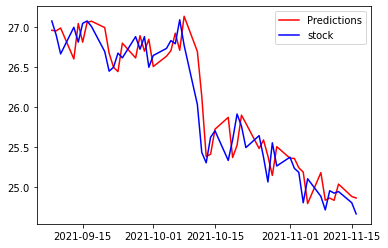

In [4]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()


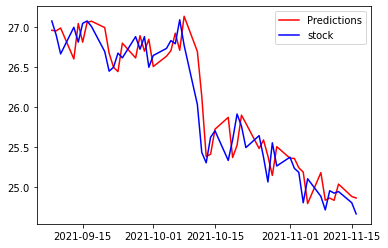

In [5]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  726
Model:               SARIMAX(6, 1, 2)   Log Likelihood                -412.859
Date:                Thu, 25 Nov 2021   AIC                            843.718
Time:                        13:22:04   BIC                            884.994
Sample:                             0   HQIC                           859.648
                                - 726                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3970      0.106    -13.230      0.000      -1.604      -1.190
ar.L2         -0.6452      0.109     -5.916      0.000      -0.859      -0.431
ar.L3         -0.0691      0.048     -1.439      0.1

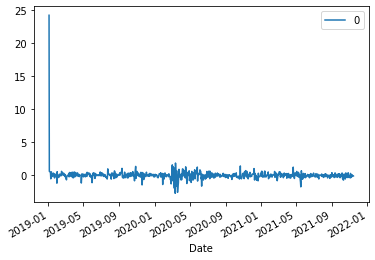

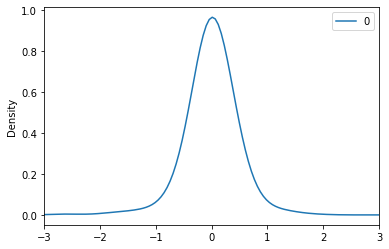

                0
count  724.000000
mean     0.034587
std      0.997456
min     -2.698953
25%     -0.180663
50%      0.023031
75%      0.216013
max     24.241259


In [6]:
arima_residuals = arima_model_fit.resid
print(model.summary())
residuals = pd.DataFrame(arima_residuals)
residuals.plot()
residuals.plot(kind='kde', xlim=(-3,3))
plt.show()
print(residuals.describe())

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3946      0.106    -13.144      0.000      -1.603      -1.187
ar.L2         -0.6423      0.110     -5.865      0.000      -0.857      -0.428
ar.L3         -0.0690      0.048     -1.436      0.151      -0.163       0.025
ar.L4         -0.2155      0.046     -4.701      0.000      -0.305      -0.126
ar.L5         -0.2490      0.046     -5.405      0.000      -0.339      -0.159
ar.L6         -0.1859      0.032     -5.793      0.000      -0.249      -0.123
ma.L1          1.3237      0.108     12.304      0.000       1.113       1.535
ma.L2          0.5732      0.095      6.025      0.000       0.387       0.760
sigma2         0.1832      0.006     32.606      0.000       0.172       0.194


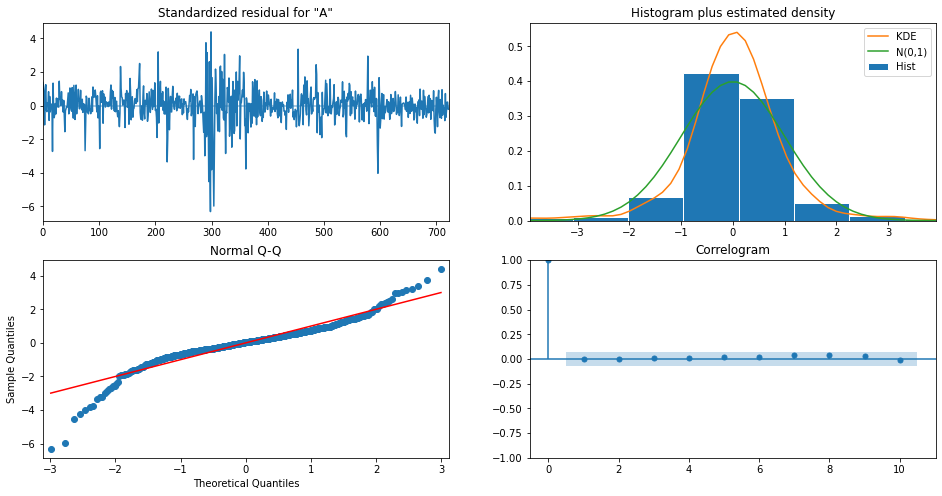

In [7]:

print(arima_model_fit.summary().tables[1])
arima_model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [8]:
stock = web.get_data_yahoo("T",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=860.056, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=904.877, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=896.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=897.290, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=902.879, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=896.050, Time=0.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=877.467, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=855.080, Time=1.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=859.919, Time=0.63 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=854.536, Time=1.24 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=861.776, Time=1.05 sec
 ARIMA(6,1,3)(0,0,0)[0] intercept   : AIC=854.429, Time=1.63 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=845.718, Time=1.02 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=852.162, Time=0.61 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=861.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex

Iteration:      1,   Func. Count:      6,   Neg. LLF: 246136180521.9793
Iteration:      2,   Func. Count:     14,   Neg. LLF: 442763691.39283
Iteration:      3,   Func. Count:     20,   Neg. LLF: 156002373415.37872
Iteration:      4,   Func. Count:     28,   Neg. LLF: 41163.53146589545
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8407.95029389105
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1439.5144390220723
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1215.4098471141306
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1195.2090635163677
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1147.8186675230263
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1224.394737798058
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1190.8573973593275
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1184.923618791638
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1153.9468702808408
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1185.5

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     14,   Func. Count:     88,   Neg. LLF: 1194.727806825243
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1113.8704059051906
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1113.3762317262324
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1113.6630580123183
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1113.0590625700625
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1112.9817163701084
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1112.981274831272
Iteration:     21,   Func. Count:    125,   Neg. LLF: 1112.98126914443
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1112.9812691185357
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1112.98126914443
            Iterations: 22
            Function evaluations: 129
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 72214344351.6788
Iteration:      2,   Func. Count:     14,   Neg. LLF: 427514937.682

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      6,   Func. Count:     40,   Neg. LLF: 1585.5813027859717
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1233.7940063717047
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1212.3625320671613
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1156.7973697177245
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1236.9472377226257
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1206.5013287426568
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1201.7073282955785
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1157.0048677324735
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1201.4834432742232
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1118.163123287839
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1118.0501067136859
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1117.8391516267648
Iteration:     18,   Func. Count:    111,   Neg. LLF: 1117.2535820779551
Iteration:     19,   Func. Count:    116,   Neg. LLF

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 423499386.3130206
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7448345386.716752
Iteration:      4,   Func. Count:     28,   Neg. LLF: 258230.95966092174
Iteration:      5,   Func. Count:     34,   Neg. LLF: 9671.359412469386
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1438.9853769898828
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1237.3157421773417
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1215.4733781175387
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1158.3100687995673
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1226.9618278999083
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1206.5835040896645
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1203.7345384345708
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1161.1472585029255
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1204.4331106447084
Iteration:     15,   Func. Count:     94,   Neg. LLF: 

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     20,   Func. Count:    119,   Neg. LLF: 1124.0703279550721
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1124.0702778129066
Iteration:     22,   Func. Count:    128,   Neg. LLF: 1124.0702778027858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1124.0702778129066
            Iterations: 22
            Function evaluations: 128
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5624609962907.578
Iteration:      2,   Func. Count:     14,   Neg. LLF: 420309468.5461986
Iteration:      3,   Func. Count:     20,   Neg. LLF: 511723499315.34814
Iteration:      4,   Func. Count:     28,   Neg. LLF: 12937.972879369498
Iteration:      5,   Func. Count:     34,   Neg. LLF: 127013.16021678879
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1441.5364491149558
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1243.3543393772347
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1221.62

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     11,   Func. Count:     70,   Neg. LLF: 1215.7891361606978
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1212.4536752834124
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1165.0936623426196
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1211.9960880571318
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1127.75361564205
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1127.3206875942271
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1127.1980808204112
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1126.9298607350593
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1126.8750813581082
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1126.8704636598336
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1126.8701894843307
Iteration:     22,   Func. Count:    128,   Neg. LLF: 1126.8701894842216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1126.8701894843307
            Itera

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     14,   Neg. LLF: 417887599.58597434
Iteration:      3,   Func. Count:     20,   Neg. LLF: 567569759644.9763
Iteration:      4,   Func. Count:     28,   Neg. LLF: 12356.792954332994
Iteration:      5,   Func. Count:     34,   Neg. LLF: 129285.04778862675
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1499.8152735968436
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1258.1769184737504
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1235.583622337791
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1169.8459800250562
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1238.6591369383668
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1226.589881155669
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1222.865504158283
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1172.470090207938
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1199.4131400400074
Iteration:     15,   Func. Count:     94,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     21,   Func. Count:    125,   Neg. LLF: 1141.064044567318
Iteration:     22,   Func. Count:    130,   Neg. LLF: 1141.0640434355923
Iteration:     23,   Func. Count:    134,   Neg. LLF: 1141.0640434103746
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1141.0640434355923
            Iterations: 23
            Function evaluations: 134
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 69665795767.4402
Iteration:      2,   Func. Count:     14,   Neg. LLF: 418536904.4340081
Iteration:      3,   Func. Count:     20,   Neg. LLF: 9914029249.460266
Iteration:      4,   Func. Count:     28,   Neg. LLF: 113568.80383132517
Iteration:      5,   Func. Count:     34,   Neg. LLF: 406699.31209903467
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1492.788721212591
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1262.1433434893117
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1243.072507

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      8,   Func. Count:     52,   Neg. LLF: 1249.162007140912
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1182.6819388695078
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1250.0210556742554
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1241.836297263549
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1237.8028261649768
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1186.438079904723
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1192.6253568017073
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1149.9546602304918
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1149.8229225573878
Iteration:     17,   Func. Count:    105,   Neg. LLF: 1149.0950227317865
Iteration:     18,   Func. Count:    110,   Neg. LLF: 1148.7842856311008
Iteration:     19,   Func. Count:    115,   Neg. LLF: 1148.67959912186
Iteration:     20,   Func. Count:    120,   Neg. LLF: 1148.6720806489657
Iteration:     21,   Func. Count:    125,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 581202065772.3184
Iteration:      2,   Func. Count:     14,   Neg. LLF: 419845197.8057529
Iteration:      3,   Func. Count:     20,   Neg. LLF: 614332835152.6338
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3934.773415399073
Iteration:      5,   Func. Count:     34,   Neg. LLF: 30222.226677330844
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1493.1654124105694
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1270.7246796954025
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1257.8209246048746
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1190.4054283448872
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1257.180401187682
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1251.3444409577755
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1247.6270095434425
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1194.8020002396206
Iteration:     14,   Func. Count:     88,   Neg. LLF: 11

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     15,   Func. Count:     94,   Neg. LLF: 1164.4785827730848
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1164.2826789134106
Iteration:     17,   Func. Count:    104,   Neg. LLF: 1163.675641202061
Iteration:     18,   Func. Count:    109,   Neg. LLF: 1163.3379633705313
Iteration:     19,   Func. Count:    114,   Neg. LLF: 1163.2631739327012
Iteration:     20,   Func. Count:    119,   Neg. LLF: 1163.2491312078773
Iteration:     21,   Func. Count:    124,   Neg. LLF: 1163.248712838726
Iteration:     22,   Func. Count:    129,   Neg. LLF: 1163.2486937631998
Iteration:     23,   Func. Count:    133,   Neg. LLF: 1163.2486937451258
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1163.2486937631998
            Iterations: 23
            Function evaluations: 133
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6643598815467.996
Iteration:      2,   Func. Count:     14,   Neg. LLF: 42042050

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      3,   Func. Count:     20,   Neg. LLF: 646438634214.1565
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3268.2423946858703
Iteration:      5,   Func. Count:     34,   Neg. LLF: 45603.426012102944
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1499.3811660085298
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1281.0282348817911
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1275.2120784788435
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1204.6769905405586
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1270.720390452049
Iteration:     11,   Func. Count:     70,   Neg. LLF: 1269.960906032733
Iteration:     12,   Func. Count:     76,   Neg. LLF: 1254.9639929421037
Iteration:     13,   Func. Count:     82,   Neg. LLF: 1210.0653780551966
Iteration:     14,   Func. Count:     88,   Neg. LLF: 1202.6618594307006
Iteration:     15,   Func. Count:     94,   Neg. LLF: 1173.449504280811
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 934282392.2773277
Iteration:      2,   Func. Count:     15,   Neg. LLF: 330074390.0791681
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1792.16836820424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.27742257890344
Iteration:      5,   Func. Count:     35,   Neg. LLF: 755.2670374806421
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.3260959091461
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.10996962944336
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.961269999347
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.7276860438102
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.2858118486395
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.1021696861998
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.08141438388657
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.0792283765335
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.07901

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 27353658879098.164
Iteration:      2,   Func. Count:     15,   Neg. LLF: 330204798.71230876
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1793.6996015664051
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.3656459026166
Iteration:      5,   Func. Count:     35,   Neg. LLF: 982.6809738821506
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.0830918986883
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.9418407437884
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.77799204481653
Iteration:      9,   Func. Count:     57,   Neg. LLF: 327.6185012550774
Iteration:     10,   Func. Count:     63,   Neg. LLF: 328.5792347850723
Iteration:     11,   Func. Count:     69,   Neg. LLF: 325.9505951061001
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.88580573393347
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.8844892227647
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325.8

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 551968938.963089
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8817655.516260628
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1795.0488675280958
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.54913760194506
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6409.2501533863715
Iteration:      6,   Func. Count:     42,   Neg. LLF: 326.810855395471
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.7147454350184
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.43552014839497
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.4509713999411
Iteration:     10,   Func. Count:     63,   Neg. LLF: 336.2412372362689
Iteration:     11,   Func. Count:     69,   Neg. LLF: 325.68844382306685
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.64163800529457
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.6378593938354
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325.63

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2815417056.1442623
Iteration:      2,   Func. Count:     15,   Neg. LLF: 331467850.94059163
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1800.053675569036
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.23622149000147
Iteration:      5,   Func. Count:     35,   Neg. LLF: 818.9323133586903
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.1865835851027
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.9891408901941
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.85008565861324
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.5469554744201
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.1756654522882
Iteration:     11,   Func. Count:     67,   Neg. LLF: 325.98110786098164
Iteration:     12,   Func. Count:     72,   Neg. LLF: 325.95754893999344
Iteration:     13,   Func. Count:     77,   Neg. LLF: 325.9549466903155
Iteration:     14,   Func. Count:     82,   Neg. LLF: 325.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28095248836970.895
Iteration:      2,   Func. Count:     15,   Neg. LLF: 10325017.885576217
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1804.036154334181
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.1803357936759
Iteration:      5,   Func. Count:     35,   Neg. LLF: 544.9422249401359
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.6430470603944
Iteration:      7,   Func. Count:     46,   Neg. LLF: 326.99300277249415
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.63056857841934
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.81263892474925
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.3569465362718
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.35540543399895
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.3553799740198
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.35537145804835
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28147885429004.402
Iteration:      2,   Func. Count:     15,   Neg. LLF: 333685230.8830745
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1806.7370052993763
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.33018106035183
Iteration:      5,   Func. Count:     35,   Neg. LLF: 518.8035364681632
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.7999110911461
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.0669906017198
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.72094062133567
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.639095669639
Iteration:     10,   Func. Count:     61,   Neg. LLF: 326.51978244002134
Iteration:     11,   Func. Count:     66,   Neg. LLF: 326.51864055952103
Iteration:     12,   Func. Count:     71,   Neg. LLF: 326.5185531432127
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.5185446064917
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.5

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 28497347748608.61
Iteration:      2,   Func. Count:     15,   Neg. LLF: 110197903.67640191
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1809.1646432587695
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.4460358124459
Iteration:      5,   Func. Count:     35,   Neg. LLF: 511.5509363840295
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.91115196172484
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.1321531897361
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.8015240866221
Iteration:      9,   Func. Count:     56,   Neg. LLF: 326.71196022509497
Iteration:     10,   Func. Count:     61,   Neg. LLF: 326.6073721563805
Iteration:     11,   Func. Count:     66,   Neg. LLF: 326.60636830400574
Iteration:     12,   Func. Count:     71,   Neg. LLF: 326.606279850828
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.6062707204803
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.60

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1166505499.5512388
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7745321.3392593535
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1810.705637117529
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5105182519444
Iteration:      5,   Func. Count:     35,   Neg. LLF: 615.7995999883117
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.75390869767205
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.4056575605272
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.28537321974886
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.5094265613194
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.4647253564854
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.4327424476084
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.4324809082671
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.4323574094711
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.43

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2818691634.636265
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12381515.823265685
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1812.2282355378575
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.532897980669
Iteration:      5,   Func. Count:     35,   Neg. LLF: 771.1100260671304
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4396794415327
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2174698618676
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1105485858939
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.3533514613953
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.2710503412298
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.2087553852358
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.208360413012
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.2082628942801
Iteration:     14,   Func. Count:     82,   Neg. LLF: 326.208251

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1068091884.1975462
Iteration:      2,   Func. Count:     15,   Neg. LLF: 22776227.601656172
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1816.4333352577132
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.4721044957013
Iteration:      5,   Func. Count:     35,   Neg. LLF: 568.298021629263
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.7899985416971
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.17129932434636
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.87141862653505
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.2905487554517
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.48426826771487
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.4812519863525
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.4812325739571
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.4812266805984
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3071504249.4370213
Iteration:      2,   Func. Count:     15,   Neg. LLF: 335686452.99873805
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1818.9682762341288
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5845217049481
Iteration:      5,   Func. Count:     35,   Neg. LLF: 552.9108676059493
Iteration:      6,   Func. Count:     41,   Neg. LLF: 327.94686082503495
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.2667737287426
Iteration:      8,   Func. Count:     51,   Neg. LLF: 326.98271919165796
Iteration:      9,   Func. Count:     56,   Neg. LLF: 328.0482108620503
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.6080104407747
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.605959689046
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.6059428731096
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.6059361637534
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.60

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1608455265.3491259
Iteration:      2,   Func. Count:     15,   Neg. LLF: 335612454.52352715
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1820.5184378380286
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.7110309527879
Iteration:      5,   Func. Count:     35,   Neg. LLF: 716.6133210559926
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.6890898852494
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.3723739264918
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2888070956634
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.50773682257625
Iteration:     10,   Func. Count:     62,   Neg. LLF: 327.58870259773363
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.4259875537949
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.4227194462614
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.4226750426157
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30474176555108.168
Iteration:      2,   Func. Count:     15,   Neg. LLF: 21863238.04866813
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1822.9899674933451
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.68036128442463
Iteration:      5,   Func. Count:     35,   Neg. LLF: 743.9408113585182
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.6250102193625
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.31085355893276
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2311241684032
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.46210362703124
Iteration:     10,   Func. Count:     62,   Neg. LLF: 329.47156064762487
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.36535575868123
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3612871558409
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3612518759804
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 644772301.7596681
Iteration:      2,   Func. Count:     15,   Neg. LLF: 336506259.650217
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1825.256875993611
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.71656459742496
Iteration:      5,   Func. Count:     35,   Neg. LLF: 846.3285032458964
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.46216310956083
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.21077070943704
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.13703784479355
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.38713282939796
Iteration:     10,   Func. Count:     62,   Neg. LLF: 334.7713904821645
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.2680037322077
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.25837750573135
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.258368069912
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.25

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4874962118.154169
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337204827.9550758
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1827.90157309007
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.6980896018368
Iteration:      5,   Func. Count:     35,   Neg. LLF: 773.0936616774936
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.59381122052264
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2826171807636
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2113902981255
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4864955418791
Iteration:     10,   Func. Count:     62,   Neg. LLF: 351.82181470890134
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.35280781848724
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3479463192104
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3477084493901
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.3476

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18202595000.16239
Iteration:      2,   Func. Count:     15,   Neg. LLF: 337557189.61580056
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1830.1643201159998
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.78408829118183
Iteration:      5,   Func. Count:     35,   Neg. LLF: 855.020384018019
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.4915097999017
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.2342726742441
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.17102792913846
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.49162891588804
Iteration:     10,   Func. Count:     62,   Neg. LLF: 360.12775302477996
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.3141671924577
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.30759759558447
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.30743318983014
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31677030814253.14
Iteration:      2,   Func. Count:     15,   Neg. LLF: 23665386.536197536
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1832.0811574423806
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.9027529762613
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1041.2369020767264
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.2968682940174
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.11623804402694
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.05840640872907
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.4062272976794
Iteration:     10,   Func. Count:     62,   Neg. LLF: 364.54161198682505
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.20743550228764
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.1902368753649
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.1893568250672
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 486233670.92826796
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339191611.4544428
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1837.0145680212722
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.665993878969
Iteration:      5,   Func. Count:     35,   Neg. LLF: 560.1297197306733
Iteration:      6,   Func. Count:     41,   Neg. LLF: 328.2001535144449
Iteration:      7,   Func. Count:     46,   Neg. LLF: 327.3148278088963
Iteration:      8,   Func. Count:     51,   Neg. LLF: 327.09878182043144
Iteration:      9,   Func. Count:     56,   Neg. LLF: 327.18065005119433
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.6762864731508
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.67443045280254
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.6741852580956
Iteration:     13,   Func. Count:     77,   Neg. LLF: 326.67416660471105
Iteration:     14,   Func. Count:     81,   Neg. LLF: 326.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5444894284.585065
Iteration:      2,   Func. Count:     15,   Neg. LLF: 21614097.871340122
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1838.919284944434
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.83456074887425
Iteration:      5,   Func. Count:     35,   Neg. LLF: 668.3217864104317
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.97467243525864
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.46582752865163
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.40781648611244
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.81781225426823
Iteration:     10,   Func. Count:     62,   Neg. LLF: 347.99686647407293
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.60438628063866
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.60198962017466
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.6017927582026
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 533936809.86269397
Iteration:      2,   Func. Count:     15,   Neg. LLF: 21399414.417063884
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1840.4624938965405
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.0110624154997
Iteration:      5,   Func. Count:     35,   Neg. LLF: 899.349330218158
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.5661202368514
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.27940408758536
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.2343746964252
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.7357751678215
Iteration:     10,   Func. Count:     62,   Neg. LLF: 359.30221922208534
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.4109583144476
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.4080417057766
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.40799016763197
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.4

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33095440324416.83
Iteration:      2,   Func. Count:     15,   Neg. LLF: 339558764.9167495
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1842.1704390980856
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.15948502891587
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1291.275461188272
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.2100576990079
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.0564304633061
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.01268611054854
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.5008699962837
Iteration:     10,   Func. Count:     62,   Neg. LLF: 364.7799973275791
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.1856379929093
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.1715613177488
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.17137191930067
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.17

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1417003634.0082612
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12855207.899141878
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1844.04004579612
Iteration:      4,   Func. Count:     28,   Neg. LLF: 337.40678446097945
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6772.672179613638
Iteration:      6,   Func. Count:     42,   Neg. LLF: 326.9278437163783
Iteration:      7,   Func. Count:     47,   Neg. LLF: 326.8399863768066
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.78916626913673
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.1897260431935
Iteration:     10,   Func. Count:     62,   Neg. LLF: 365.1855597380239
Iteration:     11,   Func. Count:     69,   Neg. LLF: 326.03583639146495
Iteration:     12,   Func. Count:     74,   Neg. LLF: 325.95105944921755
Iteration:     13,   Func. Count:     79,   Neg. LLF: 325.95005545368446
Iteration:     14,   Func. Count:     84,   Neg. LLF: 325.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33366010021726.18
Iteration:      2,   Func. Count:     15,   Neg. LLF: 341428354.8319893
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1849.0673373666914
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.64829928757126
Iteration:      5,   Func. Count:     35,   Neg. LLF: 727.3580124582207
Iteration:      6,   Func. Count:     42,   Neg. LLF: 327.63619252001973
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.1903644691532
Iteration:      8,   Func. Count:     52,   Neg. LLF: 327.1407844455229
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.60682612265725
Iteration:     10,   Func. Count:     62,   Neg. LLF: 352.5588944083264
Iteration:     11,   Func. Count:     68,   Neg. LLF: 326.33044255754066
Iteration:     12,   Func. Count:     73,   Neg. LLF: 326.3280970114463
Iteration:     13,   Func. Count:     78,   Neg. LLF: 326.3277357513888
Iteration:     14,   Func. Count:     83,   Neg. LLF: 326.3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33558724041239.926
Iteration:      2,   Func. Count:     15,   Neg. LLF: 342824781.49355894
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1853.323370960728
Iteration:      4,   Func. Count:     28,   Neg. LLF: 336.5999887661805
Iteration:      5,   Func. Count:     35,   Neg. LLF: 477.043602992146
Iteration:      6,   Func. Count:     41,   Neg. LLF: 328.57938880368454
Iteration:      7,   Func. Count:     47,   Neg. LLF: 327.1648011402065
Iteration:      8,   Func. Count:     52,   Neg. LLF: 326.8214105752326
Iteration:      9,   Func. Count:     57,   Neg. LLF: 326.77515593631404
Iteration:     10,   Func. Count:     62,   Neg. LLF: 326.77128370271134
Iteration:     11,   Func. Count:     67,   Neg. LLF: 326.7709022043445
Iteration:     12,   Func. Count:     72,   Neg. LLF: 326.77078784038036
Iteration:     13,   Func. Count:     76,   Neg. LLF: 326.7707878402561
Optimization terminated successfully    (Exit mode 0)
     

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32927256690478.867
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6581619.151132869
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1859.7677658088392
Iteration:      4,   Func. Count:     28,   Neg. LLF: 338.1313375813171
Iteration:      5,   Func. Count:     35,   Neg. LLF: 694.944958768687
Iteration:      6,   Func. Count:     42,   Neg. LLF: 329.7199839960424
Iteration:      7,   Func. Count:     47,   Neg. LLF: 329.39054328979637
Iteration:      8,   Func. Count:     52,   Neg. LLF: 329.2520487016681
Iteration:      9,   Func. Count:     57,   Neg. LLF: 328.8464731792061
Iteration:     10,   Func. Count:     62,   Neg. LLF: 328.5983997041314
Iteration:     11,   Func. Count:     67,   Neg. LLF: 328.4811981062936
Iteration:     12,   Func. Count:     72,   Neg. LLF: 328.47292712378487
Iteration:     13,   Func. Count:     77,   Neg. LLF: 328.47221687532397
Iteration:     14,   Func. Count:     82,   Neg. LLF: 328.47

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31457205368149.46
Iteration:      2,   Func. Count:     15,   Neg. LLF: 7296347.574266388
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1863.6267754550374
Iteration:      4,   Func. Count:     28,   Neg. LLF: 339.8936610316947
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5002.770926290699
Iteration:      6,   Func. Count:     42,   Neg. LLF: 330.77149860255497
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.63114812668675
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.02903973948344
Iteration:      9,   Func. Count:     57,   Neg. LLF: 330.38796298799076
Iteration:     10,   Func. Count:     63,   Neg. LLF: 329.71541425262586
Iteration:     11,   Func. Count:     68,   Neg. LLF: 329.6388264489501
Iteration:     12,   Func. Count:     73,   Neg. LLF: 329.63440460676134
Iteration:     13,   Func. Count:     78,   Neg. LLF: 329.63313587988904
Iteration:     14,   Func. Count:     83,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31811927478373.145
Iteration:      2,   Func. Count:     15,   Neg. LLF: 35214070.08175388
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1865.9980107727552
Iteration:      4,   Func. Count:     28,   Neg. LLF: 340.6227359900331
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5108.270298279948
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.102137683514
Iteration:      7,   Func. Count:     47,   Neg. LLF: 330.9847567217144
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.5749057965922
Iteration:      9,   Func. Count:     57,   Neg. LLF: 381.76017825814785
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.21493072777605
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.02455361949035
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.0151636748669
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.01154588186114
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330.0

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32681126605469.887
Iteration:      2,   Func. Count:     15,   Neg. LLF: 10284525.997641554
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1868.3028332425135
Iteration:      4,   Func. Count:     28,   Neg. LLF: 341.24950389962794
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5182.617149652597
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.33665870815855
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.2261545468979
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.868402901154
Iteration:      9,   Func. Count:     57,   Neg. LLF: 372.30205668374356
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.4381078847063
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.25236452857155
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.2435248110326
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.2412467590842
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2835522370.089345
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4102935.3151311134
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1870.2138288072365
Iteration:      4,   Func. Count:     28,   Neg. LLF: 341.16871453264196
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5241.50283897249
Iteration:      6,   Func. Count:     42,   Neg. LLF: 331.3269686826252
Iteration:      7,   Func. Count:     47,   Neg. LLF: 331.20372491017207
Iteration:      8,   Func. Count:     52,   Neg. LLF: 330.87888830705765
Iteration:      9,   Func. Count:     57,   Neg. LLF: 354.7244257981481
Iteration:     10,   Func. Count:     63,   Neg. LLF: 330.43421282787114
Iteration:     11,   Func. Count:     68,   Neg. LLF: 330.2551372345154
Iteration:     12,   Func. Count:     73,   Neg. LLF: 330.1838408121338
Iteration:     13,   Func. Count:     78,   Neg. LLF: 330.1766163049439
Iteration:     14,   Func. Count:     83,   Neg. LLF: 330.1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1113996132.5368958
Iteration:      2,   Func. Count:     15,   Neg. LLF: 126950724.52035841
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1873.7769068390064
Iteration:      4,   Func. Count:     28,   Neg. LLF: 343.27114544549215
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5135.565825581567
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.09981836700985
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.00173505934555
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.6211328929503
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.38831173579985
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.1739056087898
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.1084869317565
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.1005906481977
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.0999693174578
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1201325933.331364
Iteration:      2,   Func. Count:     15,   Neg. LLF: 352908386.7160001
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1875.6889679556782
Iteration:      4,   Func. Count:     28,   Neg. LLF: 343.95358727341545
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5169.265181184428
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.2922167071413
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.19277270050895
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.84707068126625
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.6118965510991
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.4025574211794
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.3168366335042
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.30966484920805
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.30918540105733
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4188197714.9372005
Iteration:      2,   Func. Count:     15,   Neg. LLF: 353622100.8252419
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1877.8214144749472
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.0926032596863
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1240.2550617313802
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.6030198551945
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.4905744529343
Iteration:      8,   Func. Count:     52,   Neg. LLF: 331.9876236593704
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.81931352080755
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.6672584224465
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.62750244661356
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.6267742957874
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.6267108357868
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1085973261.670833
Iteration:      2,   Func. Count:     15,   Neg. LLF: 353807066.59531343
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1879.344728879157
Iteration:      4,   Func. Count:     28,   Neg. LLF: 344.8445828653
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5191.2028681436195
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.6341512494738
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.53097428976207
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.0326583557419
Iteration:      9,   Func. Count:     57,   Neg. LLF: 331.8669078146154
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.7077547959192
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.66586353588167
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.6649985870212
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.66491003096763
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.6649

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 949139929.4962286
Iteration:      2,   Func. Count:     15,   Neg. LLF: 354309343.4206742
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1881.4474510545779
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.3806212502422
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1669.229684302409
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.83536034976237
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.72813570655865
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.2666817183635
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.07528312136253
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.8869183971012
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.8771333358443
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.87616841979616
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.8761485758896
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.8

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 615366959.2590729
Iteration:      2,   Func. Count:     15,   Neg. LLF: 103117886.52071166
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1882.8017678669883
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.12205116027644
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5217.599362158397
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.7768270201004
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.67358603561115
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.1907793058373
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.3589383398321
Iteration:     10,   Func. Count:     63,   Neg. LLF: 331.8986434265413
Iteration:     11,   Func. Count:     68,   Neg. LLF: 331.81473891837027
Iteration:     12,   Func. Count:     73,   Neg. LLF: 331.8130069155013
Iteration:     13,   Func. Count:     78,   Neg. LLF: 331.8128647562187
Iteration:     14,   Func. Count:     83,   Neg. LLF: 331.8

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34229750496048.844
Iteration:      2,   Func. Count:     15,   Neg. LLF: 354677905.7247149
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1884.5213340399525
Iteration:      4,   Func. Count:     28,   Neg. LLF: 345.3970663918493
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1819.3605728106877
Iteration:      6,   Func. Count:     42,   Neg. LLF: 332.88306185952547
Iteration:      7,   Func. Count:     47,   Neg. LLF: 332.77638444959047
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.281207234461
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.19706243284884
Iteration:     10,   Func. Count:     62,   Neg. LLF: 331.9463287554887
Iteration:     11,   Func. Count:     67,   Neg. LLF: 331.92185305556114
Iteration:     12,   Func. Count:     72,   Neg. LLF: 331.92023035896864
Iteration:     13,   Func. Count:     77,   Neg. LLF: 331.920160590863
Iteration:     14,   Func. Count:     82,   Neg. LLF: 331.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3142096125.396927
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9052998.531062065
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1886.8921689769425
Iteration:      4,   Func. Count:     28,   Neg. LLF: 346.5472678602985
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1096.097941712087
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.18170985668604
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.0662217710087
Iteration:      8,   Func. Count:     52,   Neg. LLF: 332.5788822739978
Iteration:      9,   Func. Count:     57,   Neg. LLF: 332.6375602520224
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.2941868744225
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.23182594614116
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.2304329043326
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.23037522700514
Iteration:     14,   Func. Count:     82,   Neg. LLF: 332.23

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34623681216461.438
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356219421.0939325
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1890.0708464441354
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.705855684627
Iteration:      5,   Func. Count:     35,   Neg. LLF: 880.9473822268
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.75269641682064
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.59518807116615
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.13696999822076
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.22928081434304
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.8789290887323
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.8001177666161
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.79843979276234
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.7983568613195
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.798

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34496211573261.414
Iteration:      2,   Func. Count:     15,   Neg. LLF: 356589889.49642897
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1891.996891390668
Iteration:      4,   Func. Count:     28,   Neg. LLF: 350.3889855218424
Iteration:      5,   Func. Count:     35,   Neg. LLF: 871.468703485948
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.96435754515505
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.8088173725062
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.3666049869923
Iteration:      9,   Func. Count:     57,   Neg. LLF: 335.0084415714584
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.10838259761215
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.02807282118977
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.02633767462703
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.02622681566265
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 34888230571168.727
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6480905.520113477
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1893.1352097758102
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.33930062013087
Iteration:      5,   Func. Count:     35,   Neg. LLF: 920.4280858783977
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.85080101885444
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.71634196571847
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.3785918365223
Iteration:      9,   Func. Count:     57,   Neg. LLF: 357.69953596740464
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.048149855905
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.9224335288094
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.91723724468164
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.9162401894739
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35170541722564.92
Iteration:      2,   Func. Count:     15,   Neg. LLF: 44796829.332068145
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1894.55785081948
Iteration:      4,   Func. Count:     28,   Neg. LLF: 348.5997973157945
Iteration:      5,   Func. Count:     35,   Neg. LLF: 956.4837303158072
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.7243035053826
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.5969191892944
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.2829871870201
Iteration:      9,   Func. Count:     57,   Neg. LLF: 353.90927402039694
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.91684102006565
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.7978940221644
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.78099125432465
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.77956152911236
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.77

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 808132839.0969979
Iteration:      2,   Func. Count:     15,   Neg. LLF: 21373787.568290997
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1895.4973397225745
Iteration:      4,   Func. Count:     28,   Neg. LLF: 347.2847092229586
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1045.7923132600795
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.497816487376
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.38387454776984
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.1088595619673
Iteration:      9,   Func. Count:     57,   Neg. LLF: 349.7297811688651
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.7290704753412
Iteration:     11,   Func. Count:     68,   Neg. LLF: 332.6087060725276
Iteration:     12,   Func. Count:     73,   Neg. LLF: 332.54769104467925
Iteration:     13,   Func. Count:     78,   Neg. LLF: 332.5450741809493
Iteration:     14,   Func. Count:     83,   Neg. LLF: 332.54

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35673510903050.09
Iteration:      2,   Func. Count:     15,   Neg. LLF: 23128605.0578688
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1900.591762543487
Iteration:      4,   Func. Count:     28,   Neg. LLF: 352.4224100556232
Iteration:      5,   Func. Count:     35,   Neg. LLF: 834.1544249460326
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.1014895356168
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.91696095737404
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.5963934776013
Iteration:      9,   Func. Count:     57,   Neg. LLF: 345.4646704030984
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.22577822219523
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.16492265870784
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.14399147278783
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.14319704153775
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.14

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1046210023.8528112
Iteration:      2,   Func. Count:     15,   Neg. LLF: 31470984.746511564
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1903.1958901577295
Iteration:      4,   Func. Count:     28,   Neg. LLF: 354.41885626477404
Iteration:      5,   Func. Count:     35,   Neg. LLF: 802.4437636198654
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.31552651704044
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.097472684469
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.7928265522677
Iteration:      9,   Func. Count:     57,   Neg. LLF: 341.71702196926867
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.40325264890123
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.35623974761586
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.34486639462864
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.34439268567894
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36247981664379.39
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358633395.9690946
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1905.9397721352736
Iteration:      4,   Func. Count:     28,   Neg. LLF: 356.54486528097857
Iteration:      5,   Func. Count:     35,   Neg. LLF: 780.6266287265696
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.5505825520044
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.30521731551715
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.9676676152783
Iteration:      9,   Func. Count:     57,   Neg. LLF: 343.43231328028867
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.62094429709526
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.5828818106116
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.57464808727394
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.5742530653612
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36630583628011.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 34202372.44513203
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1907.4553576192025
Iteration:      4,   Func. Count:     28,   Neg. LLF: 355.351362613178
Iteration:      5,   Func. Count:     35,   Neg. LLF: 798.2505439670622
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.50416696355336
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.27997775473324
Iteration:      8,   Func. Count:     52,   Neg. LLF: 334.0335276899284
Iteration:      9,   Func. Count:     57,   Neg. LLF: 337.833732425462
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.60198452084694
Iteration:     11,   Func. Count:     68,   Neg. LLF: 333.54431887707483
Iteration:     12,   Func. Count:     73,   Neg. LLF: 333.53700042854405
Iteration:     13,   Func. Count:     78,   Neg. LLF: 333.53631344491475
Iteration:     14,   Func. Count:     83,   Neg. LLF: 333.53

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 543734285.2421905
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9437289.796358364
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1908.7272822846653
Iteration:      4,   Func. Count:     28,   Neg. LLF: 353.7647709769228
Iteration:      5,   Func. Count:     35,   Neg. LLF: 822.2651129972692
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.36006205523654
Iteration:      7,   Func. Count:     47,   Neg. LLF: 334.14898319296174
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.96078975485057
Iteration:      9,   Func. Count:     57,   Neg. LLF: 335.3910804974156
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.5081494621537
Iteration:     11,   Func. Count:     69,   Neg. LLF: 333.3924708037687
Iteration:     12,   Func. Count:     74,   Neg. LLF: 333.3844093796107
Iteration:     13,   Func. Count:     79,   Neg. LLF: 333.3842751751905
Iteration:     14,   Func. Count:     84,   Neg. LLF: 333.38

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 417545468.2343422
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358800716.7063725
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1909.985391077828
Iteration:      4,   Func. Count:     28,   Neg. LLF: 351.7611721472299
Iteration:      5,   Func. Count:     35,   Neg. LLF: 859.3653005560094
Iteration:      6,   Func. Count:     42,   Neg. LLF: 334.07762965020567
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.88678388074925
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.73049691260917
Iteration:      9,   Func. Count:     57,   Neg. LLF: 334.32289649290897
Iteration:     10,   Func. Count:     63,   Neg. LLF: 333.2621477585626
Iteration:     11,   Func. Count:     69,   Neg. LLF: 333.1071771111663
Iteration:     12,   Func. Count:     74,   Neg. LLF: 333.09788046763765
Iteration:     13,   Func. Count:     79,   Neg. LLF: 333.0976844719372
Iteration:     14,   Func. Count:     84,   Neg. LLF: 333.0

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38200760930526.125
Iteration:      2,   Func. Count:     15,   Neg. LLF: 358844002.98681617
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1911.1779331563673
Iteration:      4,   Func. Count:     28,   Neg. LLF: 349.75224559778997
Iteration:      5,   Func. Count:     35,   Neg. LLF: 914.4067737724387
Iteration:      6,   Func. Count:     42,   Neg. LLF: 333.77769572923603
Iteration:      7,   Func. Count:     47,   Neg. LLF: 333.6134544991851
Iteration:      8,   Func. Count:     52,   Neg. LLF: 333.4805402166697
Iteration:      9,   Func. Count:     57,   Neg. LLF: 333.6792544155805
Iteration:     10,   Func. Count:     63,   Neg. LLF: 332.98106573684527
Iteration:     11,   Func. Count:     69,   Neg. LLF: 332.81669062589106
Iteration:     12,   Func. Count:     74,   Neg. LLF: 332.80585516941824
Iteration:     13,   Func. Count:     79,   Neg. LLF: 332.8055153841784
Iteration:     14,   Func. Count:     84,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


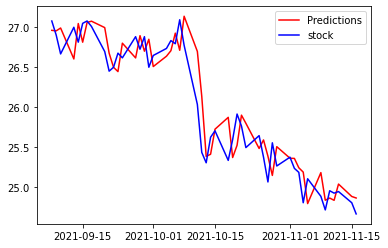

In [9]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

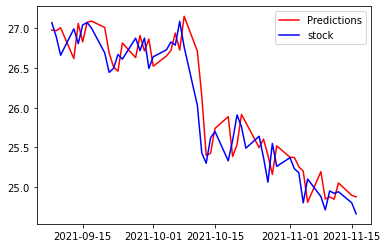

In [10]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

In [11]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

0.8537695566534284
5.165797375350317
0.869931194988105


In [12]:
stock = web.get_data_yahoo("NVDA",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3797.770, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3797.602, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3797.312, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3797.646, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3804.109, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3794.222, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3796.220, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3796.221, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3797.375, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3798.222, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3800.068, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.806 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19006.386170719412
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3361.524030271218
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3259.654939569349
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3588.248417158191
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4520.292018250205
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3429.96045828936
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3191.8629717441036
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3188.2470051706196
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3181.80151164824
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3315.924277655735
Iteration:     11,   Func. Count:     63,   Neg. LLF: 3278.4004125773495
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3676.4125577487694
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3122.251048776093
Iteration:     14,   Func. Count:     80,   Neg. LLF: 3152.64

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19090.82565479885
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3398.598460353006
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3373.0603647888656
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3250.8749245998106
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4013.6696536445374
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3210.2513002771298
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3206.0319353360233
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3176.7289664381833
Iteration:      9,   Func. Count:     49,   Neg. LLF: 3734.5624945083937
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3249.747340820658
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3152.180968669276
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3190.278304346799
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3113.7392878285305
Iteration:     14,   Func. Count:     77,   Neg. LLF: 31

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3432.4235148919142
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3309.3614337775766
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4199.700991804535
Iteration:      5,   Func. Count:     29,   Neg. LLF: 3244.649670942749
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3233.4570965583353
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3220.0998969695256
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3463.1414528636756
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3823.696351071467
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4038.693349143596
Iteration:     11,   Func. Count:     63,   Neg. LLF: 4322.728047392894
Iteration:     12,   Func. Count:     69,   Neg. LLF: 4101.795717495637
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3193.9553867098502
Iteration:     14,   Func. Count:     80,   Neg. LLF: 160769.39248540267
Iteration:     15,   Func. Count:     86,   Neg. LLF: 454

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     20,   Func. Count:    117,   Neg. LLF: 4099.535121277342
Iteration:     21,   Func. Count:    123,   Neg. LLF: 4051.1901372145057
Iteration:     22,   Func. Count:    129,   Neg. LLF: 3170.879953781382
Iteration:     23,   Func. Count:    134,   Neg. LLF: 3533.678038187102
Iteration:     24,   Func. Count:    140,   Neg. LLF: 3994.266329082037
Iteration:     25,   Func. Count:    146,   Neg. LLF: 3254.936840453968
Iteration:     26,   Func. Count:    152,   Neg. LLF: 3532.811001239368
Iteration:     27,   Func. Count:    158,   Neg. LLF: 3305.4154324425454
Iteration:     28,   Func. Count:    164,   Neg. LLF: 3292.0262753646407
Iteration:     29,   Func. Count:    170,   Neg. LLF: 3281.686060474342
Iteration:     30,   Func. Count:    176,   Neg. LLF: 3272.7168010701575
Iteration:     31,   Func. Count:    182,   Neg. LLF: 3170.031851293725
Iteration:     32,   Func. Count:    188,   Neg. LLF: 3162.4011371127076
Iteration:     33,   Func. Count:    193,   Neg. LLF: 3162.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     33,   Func. Count:    194,   Neg. LLF: 3175.256675919372
Iteration:     34,   Func. Count:    199,   Neg. LLF: 3175.2560516416843
Iteration:     35,   Func. Count:    204,   Neg. LLF: 3175.2560430044523
Iteration:     36,   Func. Count:    209,   Neg. LLF: 3175.2560394301418
Iteration:     37,   Func. Count:    213,   Neg. LLF: 3175.256039310276
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3175.2560394301418
            Iterations: 39
            Function evaluations: 213
            Gradient evaluations: 37
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19401.661742148644
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3505.702973009259
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4199.058243929447
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5124.257390839002
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3345.0289894447833
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3291.97968

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     12,   Func. Count:     72,   Neg. LLF: 210552.62420900006
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3717.0626633564034
Iteration:     14,   Func. Count:     84,   Neg. LLF: 3360.907486141521
Iteration:     15,   Func. Count:     90,   Neg. LLF: 4085.9945756507714
Iteration:     16,   Func. Count:     96,   Neg. LLF: 3487.876890183654
Iteration:     17,   Func. Count:    102,   Neg. LLF: 3332.536780909961
Iteration:     18,   Func. Count:    108,   Neg. LLF: 3216.4417128965897
Iteration:     19,   Func. Count:    113,   Neg. LLF: 3236.682272003188
Iteration:     20,   Func. Count:    119,   Neg. LLF: 3567.603060348122
Iteration:     21,   Func. Count:    125,   Neg. LLF: 3904.4442120374806
Iteration:     22,   Func. Count:    131,   Neg. LLF: 3295.6971447825454
Iteration:     23,   Func. Count:    137,   Neg. LLF: 3458.327669868896
Iteration:     24,   Func. Count:    143,   Neg. LLF: 3433.1701974614225
Iteration:     25,   Func. Count:    149,   Neg. LLF: 333

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      8,   Func. Count:     49,   Neg. LLF: 3315.3053692156263
Iteration:      9,   Func. Count:     54,   Neg. LLF: 7254.205250038636
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3521.2293708023726
Iteration:     11,   Func. Count:     66,   Neg. LLF: 3602.3654604168146
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3600.642965489493
Iteration:     13,   Func. Count:     78,   Neg. LLF: 3592.6861093590605
Iteration:     14,   Func. Count:     84,   Neg. LLF: 3261.030939114431
Iteration:     15,   Func. Count:     89,   Neg. LLF: 332517.5181192692
Iteration:     16,   Func. Count:     95,   Neg. LLF: 3285.7042669860043
Iteration:     17,   Func. Count:    101,   Neg. LLF: 4036.0646129685247
Iteration:     18,   Func. Count:    107,   Neg. LLF: 3846.0030654835346
Iteration:     19,   Func. Count:    113,   Neg. LLF: 4241.198251633497
Iteration:     20,   Func. Count:    119,   Neg. LLF: 4102.1069189130785
Iteration:     21,   Func. Count:    125,   Neg. LLF: 33

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19627.354435207842
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3565.5431480705993
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3776.7303479640022
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5078.016928467846
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4212.07030253134
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3350.673991661854
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3344.1605968322992
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3340.423040045781
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3334.4900007767583
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3283.2015184475235
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3367.7006008120643
Iteration:     12,   Func. Count:     68,   Neg. LLF: 3719.2570341017877
Iteration:     13,   Func. Count:     74,   Neg. LLF: 3687.2569380160085
Iteration:     14,   Func. Count:     80,   Neg. LLF: 36

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3587.879517060647
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3464.1671707713795
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3576.6302078984754
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3365.2791126508664
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3365.2476910329656
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3357.9716524573787
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3340.693928969176
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4148.12058908791
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3517.156603922239
Iteration:     11,   Func. Count:     63,   Neg. LLF: 3561.9072404452586
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3545.517943466538
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3522.2883344623515
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3280.164365811789
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3263

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19797.62945280663
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3610.6370530499166
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3391.1386829233916
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4887.500322878968
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3382.9671552773243
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3372.9520690360114
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3549.24989850334
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3372.162377286768
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3463.1548029099213
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3702.2164881803537
Iteration:     11,   Func. Count:     64,   Neg. LLF: 3614.361358088211
Iteration:     12,   Func. Count:     70,   Neg. LLF: 3452.912978423975
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3306.947407684307
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3447.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3656.4351321521035
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3532.1562905162964
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4987.915966760189
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3866.4408050751094
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3470.5323080226635
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3423.598900017345
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3420.3655076652904
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3400.1675002151533
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4247.179912389505
Iteration:     11,   Func. Count:     63,   Neg. LLF: 3515.1862180215303
Iteration:     12,   Func. Count:     69,   Neg. LLF: 3521.698650943391
Iteration:     13,   Func. Count:     75,   Neg. LLF: 3525.503202499701
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3337.185097995512
Iteration:     15,   Func. Count:     86,   Neg. LLF: 338

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

            Gradient evaluations: 35
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20057.776826638794
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3679.4907063024966
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3614.509368224542
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4936.835315836963
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4386.7670055082235
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3445.29056835945
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3434.2057110501946
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4258.36892016378
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3728.0874094368005
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3536.4633855161937
Iteration:     11,   Func. Count:     64,   Neg. LLF: 3535.869366017184
Iteration:     12,   Func. Count:     70,   Neg. LLF: 3435.0829032588695
Iteration:     13,   Func. Count:     76,   Neg. LLF: 166700.2828535733
Iteration:     14,   F

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     21,   Func. Count:    123,   Neg. LLF: 3423.5511614615325
Iteration:     22,   Func. Count:    129,   Neg. LLF: 3351.243069563594
Iteration:     23,   Func. Count:    135,   Neg. LLF: 3346.727692348936
Iteration:     24,   Func. Count:    140,   Neg. LLF: 3346.711746364377
Iteration:     25,   Func. Count:    145,   Neg. LLF: 3346.8794998498747
Iteration:     26,   Func. Count:    151,   Neg. LLF: 3346.6800641700847
Iteration:     27,   Func. Count:    156,   Neg. LLF: 3346.6780911612595
Iteration:     28,   Func. Count:    161,   Neg. LLF: 3346.6780819033393
Iteration:     29,   Func. Count:    165,   Neg. LLF: 3346.6780817804083
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3346.6780819033393
            Iterations: 30
            Function evaluations: 165
            Gradient evaluations: 29
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20146.75372222883
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3702.2565

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3717.548465842855
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3695.2302178491373
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3877.483702550341
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5041.5673484777435
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4041.3940547189886
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4895.772467980789
Iteration:      8,   Func. Count:     49,   Neg. LLF: 3506.655444167458
Iteration:      9,   Func. Count:     55,   Neg. LLF: 3479.9069145230587
Iteration:     10,   Func. Count:     60,   Neg. LLF: 3469.3636768512424
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3632.423978382661
Iteration:     12,   Func. Count:     71,   Neg. LLF: 3913.515611221763
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3493.6176677142594
Iteration:     14,   Func. Count:     83,   Neg. LLF: 3473.05691311019
Iteration:     15,   Func. Count:     89,   Neg. LLF: 3477.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     10,   Func. Count:     56,   Neg. LLF: 3475.507914157787
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3727.1286333568223
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3662.960455317683
Iteration:     13,   Func. Count:     73,   Neg. LLF: 4106.245923172486
Iteration:     14,   Func. Count:     79,   Neg. LLF: 3710.913768188012
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3649.6918792573497
Iteration:     16,   Func. Count:     91,   Neg. LLF: 3421.345561030681
Iteration:     17,   Func. Count:     96,   Neg. LLF: 4248.046398949078
Iteration:     18,   Func. Count:    102,   Neg. LLF: 7907.309611003862
Iteration:     19,   Func. Count:    108,   Neg. LLF: 3554.6369489847334
Iteration:     20,   Func. Count:    114,   Neg. LLF: 4163.531948994254
Iteration:     21,   Func. Count:    120,   Neg. LLF: 3627.787562542457
Iteration:     22,   Func. Count:    126,   Neg. LLF: 3698.435319695025
Iteration:     23,   Func. Count:    132,   Neg. LLF: 3880.76

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3755.4529724276263
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3748.895653118039
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3597.660277459352
Iteration:      5,   Func. Count:     28,   Neg. LLF: 5022.18486221167
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3967.312057820885
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3576.417198888902
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3518.98674544496
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3516.115792890163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3494.2923685383585
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4260.071411392037
Iteration:     12,   Func. Count:     68,   Neg. LLF: 3629.1690030750087
Iteration:     13,   Func. Count:     74,   Neg. LLF: 3602.0002545664797
Iteration:     14,   Func. Count:     80,   Neg. LLF: 3598.3676060887133
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3599.29

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3537.2358266008678
Iteration:      2,   Func. Count:     14,   Neg. LLF: 51311.3685247082
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1536.6042889105413
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1568.1563704937037
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1535.8517380652424
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1520.784538451614
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1520.7941801278566
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1520.752426657279
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1520.7524104787203
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1520.7524097963683
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1520.7524104787203
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3555.62754

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3554.1466266087596
Iteration:      2,   Func. Count:     14,   Neg. LLF: 46377.56013465444
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1543.844105781345
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1576.8757618500986
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1543.109264968963
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1527.9034627174742
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1527.9135189582123
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1527.8721083875137
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1527.8720916518578
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1527.8720910089141
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1527.8720916518578
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3564.2687

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3557.299513162546
Iteration:      2,   Func. Count:     14,   Neg. LLF: 169433.56632280996
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1550.9147589802842
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1572.9097452494195
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1548.7118672337601
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1534.8859690498284
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1534.8904855055355
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1534.858026370819
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1534.8580113019286
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1534.8580106721477
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1534.8580113019286
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3504.619

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3557.0961389393296
Iteration:      2,   Func. Count:     14,   Neg. LLF: 299741.69435037154
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1563.2350493425158
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1568.8438504497713
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1562.7547075499256
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1547.4937675798242
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1547.5071439577468
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1547.4803583598818
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1547.4803436604648
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1547.4803427689017
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1547.4803436604648
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3588.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      2,   Func. Count:     14,   Neg. LLF: 200872.85920477685
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1569.2896537336046
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1578.558391912952
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1568.7079715035793
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1553.524350964051
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1553.5382765135842
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1553.5060113233028
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1553.506001760863
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1553.506000864659
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1553.506001760863
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3552.389915008689
Iteration:      2,   Func. Count:     14,   Neg. LLF: 85071.732844

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3478.1194912211813
Iteration:      2,   Func. Count:     14,   Neg. LLF: 227062.26559357872
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1580.143454141989
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1566.995191360377
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1565.3763082706082
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1564.134309237098
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1564.093751360725
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1564.092583754957
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1564.092573632919
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1564.092572651916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1564.092573632919
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3499.621195832

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3440.193306633255
Iteration:      2,   Func. Count:     14,   Neg. LLF: 651802.185748469
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1590.3061989235848
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1577.1213532963152
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1574.6868196978219
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1574.2878001619183
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1574.2404825532954
Iteration:      8,   Func. Count:     48,   Neg. LLF: 1574.2388378532592
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1574.2385611246864
Iteration:     10,   Func. Count:     57,   Neg. LLF: 1574.2385600736852
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1574.2385611246864
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3488.3043

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      3,   Func. Count:     21,   Neg. LLF: 1596.3352695398135
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1584.1573599569483
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1582.3408844880983
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1580.2774230812147
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1580.2536786011015
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1580.2462974431646
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1580.2462521780653
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1580.2462511572278
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1580.2462521780653
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3538.7205926424303
Iteration:      2,   Func. Count:     14,   Neg. LLF: 63907.789144370094
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1599.1

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3522.3851573900106
Iteration:      2,   Func. Count:     14,   Neg. LLF: 200094.3488200782
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1604.488780617265
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1592.1289344165943
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1589.9922439144277
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1588.4567474256628
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1588.4286786799007
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1588.4244404043166
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1588.424412292301
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1588.4244113490436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1588.424412292301
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3525.08250

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3588.3144354373044
Iteration:      2,   Func. Count:     14,   Neg. LLF: 148047.37493086248
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1613.7747136103176
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1604.2136740466935
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1609.5908324436791
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1597.9538550435311
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1597.951606515936
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1597.955305305486
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1597.9420253016542
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1597.9420242975657
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1597.9420253016542
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3598.515

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3622.959427036221
Iteration:      2,   Func. Count:     14,   Neg. LLF: 171241.08896690136
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1621.4325286909725
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1613.6918596638307
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1622.931997524861
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1605.6671410724844
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1605.662688485924
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1605.662713327216
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1605.661676826861
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1605.6615512204683
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1605.6615502951138
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1605.6615512204683
            Iterations: 11
            Function evaluations: 64
            Gradient evaluati

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3653.326803874178
Iteration:      2,   Func. Count:     14,   Neg. LLF: 254218.89919475585
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1629.5115740375168
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1624.26101326274
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1630.3388475234149
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1613.815887004971
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1613.81494437325
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1613.8127993119708
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1613.812038930249
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1613.8120398465853
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3674.6445068400276
Iteration:      2,   Func. Count:     14,   Neg. LLF: 249900.10720999

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3774.5834919308954
Iteration:      2,   Func. Count:     14,   Neg. LLF: 299285.44719997107
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1646.1047319361132
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1649.3665024053093
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1659.4083625669023
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1630.665386591517
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1630.767647353032
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1630.6562725034355
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1630.6562306300596
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1630.6562292178646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1630.6562306300596
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3793.436

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3840.503609729556
Iteration:      2,   Func. Count:     14,   Neg. LLF: 113374.84969291052
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1665.905098983929
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1655.8635889784919
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1644.7897924550498
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1640.9765694715857
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1640.1925697089441
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1640.1104268235783
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1640.1005800900953
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1640.1002749796162
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1640.1002744892394
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1640.1002744892394
            Iterations: 11
            Function evaluations: 64
            Gradient evalu

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4027.4547455724514
Iteration:      2,   Func. Count:     15,   Neg. LLF: 201705.85599303272
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1683.2387571086028
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1684.0104902999437
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1679.5663077830877
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1668.1095836870197
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1669.1883845439834
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1668.1067995075834
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1668.106585671213
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1668.1065830594027
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1668.106585671213
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4031.733

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4045.880988263196
Iteration:      2,   Func. Count:     15,   Neg. LLF: 164044.93099336047
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1694.970986036782
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1696.133721883543
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1693.7632364623307
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1680.441224707675
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1680.8275698120856
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1680.4397799343405
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1680.4397553444644
Iteration:     10,   Func. Count:     61,   Neg. LLF: 1680.439752828148
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1680.4397553444644
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4002.576453

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4058.5249835088625
Iteration:      2,   Func. Count:     15,   Neg. LLF: 970000.0001039384
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1704.9046221999974
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1706.6429344664823
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1705.9958815653367
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1689.9102522037128
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1689.9119803401209
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1689.9101560245133
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1689.9098111339981
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1689.9098135944137
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4047.5649624056978
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1310159.4

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


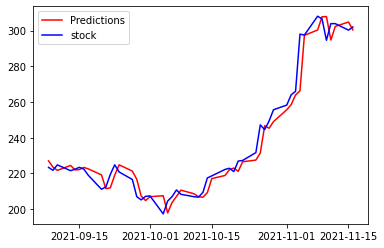

In [13]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

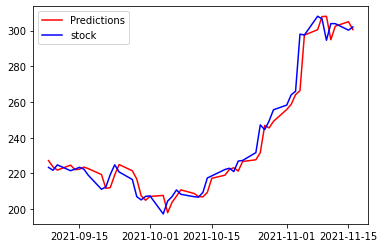

In [14]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

In [15]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

1.9075577722517603
81.08410347904773
1.8927957683935799


In [16]:
stock = web.get_data_yahoo("MSFT",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3854.338, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3818.683, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3822.513, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3859.283, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3819.786, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3819.830, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3821.786, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3827.463, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.751 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  726
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1906.342
Date:                Thu, 25 Nov 2021   AIC           

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A dat

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19008.986903753335
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3422.7247600153105
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3420.9236219938566
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3420.558715101226
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3420.3719503553543
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3419.671258851778
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3418.7061907745137
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3417.4160888531187
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3414.5483513036916
Iteration:     10,   Func. Count:     53,   Neg. LLF: 9705.341846581032
Iteration:     11,   Func. Count:     59,   Neg. LLF: 20353.988643664856
Iteration:     12,   Func. Count:     65,   Neg. LLF: 7528.944916541346
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3607.524226037664
Iteration:     14,   Func. Count:     77,   Neg. LLF: 36

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3442.347114896834
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3440.016927939565
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3439.327178355261
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3439.194869550861
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3438.5170645458493
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3435.417215865802
Iteration:      8,   Func. Count:     43,   Neg. LLF: 8770.272533811556
Iteration:      9,   Func. Count:     49,   Neg. LLF: 6385.315800861432
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3496.8277411516447
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3500.6009094876317
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3493.516252599506
Iteration:     13,   Func. Count:     73,   Neg. LLF: 3878.953197180619
Iteration:     14,   Func. Count:     79,   Neg. LLF: 3480.488037325362
Iteration:     15,   Func. Count:     85,   Neg. LLF: 3428.90

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19180.584103618086
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3462.136926625807
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3459.455191817967
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3458.2892560644623
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3458.1002920504247
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3457.737924379198
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3457.289055755667
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3454.348523090382
Iteration:      9,   Func. Count:     48,   Neg. LLF: 5744.420746840317
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3867.3960620042317
Iteration:     11,   Func. Count:     60,   Neg. LLF: 6515.333837324633
Iteration:     12,   Func. Count:     66,   Neg. LLF: 6083.949073761138
Iteration:     13,   Func. Count:     72,   Neg. LLF: 5628.320323494244
Iteration:     14,   Func. Count:     78,   Neg. LLF: 14981.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3481.89963796635
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3479.1439994541947
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3478.0584710763187
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3477.296791830716
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3482.1067300906934
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3476.7216201127217
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3476.288543853278
Iteration:      9,   Func. Count:     49,   Neg. LLF: 3474.1585863703185
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3470.6642575781034
Iteration:     11,   Func. Count:     59,   Neg. LLF: 5163.048332996078
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3780.5986286154875
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3890.478741615779
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4102.068052027194
Iteration:     15,   Func. Count:     83,   Neg. LLF: 3679

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     28,   Func. Count:    160,   Neg. LLF: 3466.782530182624
Iteration:     29,   Func. Count:    165,   Neg. LLF: 3466.6819512774186
Iteration:     30,   Func. Count:    170,   Neg. LLF: 3466.5649018874956
Iteration:     31,   Func. Count:    175,   Neg. LLF: 3466.525521834761
Iteration:     32,   Func. Count:    180,   Neg. LLF: 3466.5218261945747
Iteration:     33,   Func. Count:    185,   Neg. LLF: 3466.521780569155
Iteration:     34,   Func. Count:    190,   Neg. LLF: 3466.521779766474
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3466.521779766474
            Iterations: 35
            Function evaluations: 190
            Gradient evaluations: 34
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19352.77917254941
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3501.5235787370793
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3498.951981954712
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3497.2007648

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     21,   Func. Count:    117,   Neg. LLF: 3485.380040852375
Iteration:     22,   Func. Count:    122,   Neg. LLF: 3485.09673269791
Iteration:     23,   Func. Count:    127,   Neg. LLF: 3485.0525142844617
Iteration:     24,   Func. Count:    132,   Neg. LLF: 3485.0437964363828
Iteration:     25,   Func. Count:    137,   Neg. LLF: 3485.0423792142124
Iteration:     26,   Func. Count:    142,   Neg. LLF: 3485.0423639075316
Iteration:     27,   Func. Count:    146,   Neg. LLF: 3485.0423637804524
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3485.0423639075316
            Iterations: 27
            Function evaluations: 146
            Gradient evaluations: 27
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19438.815058372027
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3520.8543131427814
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3518.6454919795506
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3515.586

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     19,   Func. Count:    106,   Neg. LLF: 3556.955663107282
Iteration:     20,   Func. Count:    112,   Neg. LLF: 3513.529431714043
Iteration:     21,   Func. Count:    118,   Neg. LLF: 3559.5610440099535
Iteration:     22,   Func. Count:    124,   Neg. LLF: 3548.2877827968196
Iteration:     23,   Func. Count:    130,   Neg. LLF: 3523.120132332476
Iteration:     24,   Func. Count:    136,   Neg. LLF: 5655.098955044241
Iteration:     25,   Func. Count:    142,   Neg. LLF: 3532.413192095365
Iteration:     26,   Func. Count:    148,   Neg. LLF: 3504.082603335979
Iteration:     27,   Func. Count:    153,   Neg. LLF: 3503.8313763936158
Iteration:     28,   Func. Count:    158,   Neg. LLF: 3503.788719835268
Iteration:     29,   Func. Count:    163,   Neg. LLF: 3503.5862914897352
Iteration:     30,   Func. Count:    168,   Neg. LLF: 3503.428431883157
Iteration:     31,   Func. Count:    173,   Neg. LLF: 3503.1911946372306
Iteration:     32,   Func. Count:    178,   Neg. LLF: 3503.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     16,   Func. Count:     89,   Neg. LLF: 3551.8975532443765
Iteration:     17,   Func. Count:     95,   Neg. LLF: 4150.7715063901
Iteration:     18,   Func. Count:    101,   Neg. LLF: 3707.5723529495053
Iteration:     19,   Func. Count:    107,   Neg. LLF: 3816.025765140755
Iteration:     20,   Func. Count:    113,   Neg. LLF: 32626.648110222337
Iteration:     21,   Func. Count:    119,   Neg. LLF: 3590.4093189759897
Iteration:     22,   Func. Count:    125,   Neg. LLF: 3594.656389373144
Iteration:     23,   Func. Count:    131,   Neg. LLF: 3608.4572520826882
Iteration:     24,   Func. Count:    137,   Neg. LLF: 3595.306808886058
Iteration:     25,   Func. Count:    143,   Neg. LLF: 3575.6469312157383
Iteration:     26,   Func. Count:    149,   Neg. LLF: 3614.3876837424873
Iteration:     27,   Func. Count:    155,   Neg. LLF: 3559.999940167145
Iteration:     28,   Func. Count:    161,   Neg. LLF: 3580.266200703187
Iteration:     29,   Func. Count:    167,   Neg. LLF: 3542.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      7,   Func. Count:     38,   Neg. LLF: 3562.928081201352
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3557.1064887481025
Iteration:      9,   Func. Count:     48,   Neg. LLF: 5647.256902830413
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3955.7586497543725
Iteration:     11,   Func. Count:     60,   Neg. LLF: 10577.457240676142
Iteration:     12,   Func. Count:     66,   Neg. LLF: 5277.69244793428
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4561.949577491114
Iteration:     14,   Func. Count:     78,   Neg. LLF: 3798.3814478657177
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3550.205651777399
Iteration:     16,   Func. Count:     91,   Neg. LLF: 3547.8968115333078
Iteration:     17,   Func. Count:     96,   Neg. LLF: 4022.808106338395
Iteration:     18,   Func. Count:    102,   Neg. LLF: 4106.000829444295
Iteration:     19,   Func. Count:    108,   Neg. LLF: 4073.8907174961196
Iteration:     20,   Func. Count:    114,   Neg. LLF: 4066.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 19755.198953853156
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3590.217434275538
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3589.6430127842373
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3583.832587427107
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3574.198509461833
Iteration:      6,   Func. Count:     33,   Neg. LLF: 296005.10906490043
Iteration:      7,   Func. Count:     39,   Neg. LLF: 403461.6039541384
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3534.0822333377537
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3526.8565350235203
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3525.0591308839507
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3523.2786057404473
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3512.5361097647324
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3637.151777895719
Iteration:     14,   Func. Count:     77,   Neg. LLF: 36

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:     19,   Func. Count:    106,   Neg. LLF: 3593.6137010218345
Iteration:     20,   Func. Count:    112,   Neg. LLF: 4280.828059099332
Iteration:     21,   Func. Count:    118,   Neg. LLF: 1596791183.7243109
Iteration:     22,   Func. Count:    124,   Neg. LLF: 3777.277374364485
Iteration:     23,   Func. Count:    130,   Neg. LLF: 3603.839200547783
Iteration:     24,   Func. Count:    136,   Neg. LLF: 3632.022623293934
Iteration:     25,   Func. Count:    142,   Neg. LLF: 3596.24497380268
Iteration:     26,   Func. Count:    148,   Neg. LLF: 3585.82316893228
Iteration:     27,   Func. Count:    154,   Neg. LLF: 3573.00189457162
Iteration:     28,   Func. Count:    160,   Neg. LLF: 3481.2926296895544
Iteration:     29,   Func. Count:    165,   Neg. LLF: 3479.4557689748453
Iteration:     30,   Func. Count:    170,   Neg. LLF: 3477.7658786166285
Iteration:     31,   Func. Count:    175,   Neg. LLF: 3493.0150080973217
Iteration:     32,   Func. Count:    181,   Neg. LLF: 3487.53

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3627.986409008681
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3627.906121118267
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3627.2573902315353
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3580.409345058103
Iteration:      6,   Func. Count:     33,   Neg. LLF: 8212.203620997472
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3573.241914922456
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3565.533332828692
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3563.5188807831873
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3561.826525288577
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3560.1833269429007
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3552.191277332068
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3835.524370111815
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3716.7419846587472
Iteration:     15,   Func. Count:     82,   Neg. LLF: 3556.5

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     10,   Func. Count:     56,   Neg. LLF: 31090.70376488838
Iteration:     11,   Func. Count:     62,   Neg. LLF: 5843.283617934847
Iteration:     12,   Func. Count:     68,   Neg. LLF: 5778.471111708153
Iteration:     13,   Func. Count:     74,   Neg. LLF: 4904.9101186014905
Iteration:     14,   Func. Count:     80,   Neg. LLF: 3993.011246366792
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3772.8349412375824
Iteration:     16,   Func. Count:     92,   Neg. LLF: 3707.3638814392248
Iteration:     17,   Func. Count:     98,   Neg. LLF: 3572.8480203184663
Iteration:     18,   Func. Count:    104,   Neg. LLF: 3567.1384905981804
Iteration:     19,   Func. Count:    110,   Neg. LLF: 3566.7128597152005
Iteration:     20,   Func. Count:    115,   Neg. LLF: 3566.6633819882763
Iteration:     21,   Func. Count:    120,   Neg. LLF: 3566.555121215469
Iteration:     22,   Func. Count:    125,   Neg. LLF: 3566.5487324029664
Iteration:     23,   Func. Count:    130,   Neg. LLF: 35

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     15,   Func. Count:     82,   Neg. LLF: 3585.519590653551
Iteration:     16,   Func. Count:     87,   Neg. LLF: 3585.2325729241734
Iteration:     17,   Func. Count:     92,   Neg. LLF: 3585.15914472497
Iteration:     18,   Func. Count:     97,   Neg. LLF: 3585.1349458242476
Iteration:     19,   Func. Count:    102,   Neg. LLF: 3585.126120886718
Iteration:     20,   Func. Count:    107,   Neg. LLF: 3585.1255302590644
Iteration:     21,   Func. Count:    112,   Neg. LLF: 3585.1254624278636
Iteration:     22,   Func. Count:    117,   Neg. LLF: 3585.125456854782
Iteration:     23,   Func. Count:    121,   Neg. LLF: 3585.125456854782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3585.125456854782
            Iterations: 23
            Function evaluations: 121
            Gradient evaluations: 23
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20138.60706850813
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3671.15945443

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      2,   Func. Count:     13,   Neg. LLF: 3689.248752758716
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3679.692022908875
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3785.5629349726796
Iteration:      5,   Func. Count:     29,   Neg. LLF: 3660.6165723835547
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3635.9922798624257
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3633.731985629941
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3623.6875640185185
Iteration:      9,   Func. Count:     50,   Neg. LLF: 7198.505285698911
Iteration:     10,   Func. Count:     56,   Neg. LLF: 16840.72176014369
Iteration:     11,   Func. Count:     62,   Neg. LLF: 12440.633096997373
Iteration:     12,   Func. Count:     68,   Neg. LLF: 6184.62131674269
Iteration:     13,   Func. Count:     74,   Neg. LLF: 14437.084392327473
Iteration:     14,   Func. Count:     80,   Neg. LLF: 20891.046188256154
Iteration:     15,   Func. Count:     86,   Neg. LLF: 3626

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:     10,   Func. Count:     54,   Neg. LLF: 3645.643297428187
Iteration:     11,   Func. Count:     59,   Neg. LLF: 3644.6777669813814
Iteration:     12,   Func. Count:     64,   Neg. LLF: 3637.068074022999
Iteration:     13,   Func. Count:     69,   Neg. LLF: 3634.4486768897905
Iteration:     14,   Func. Count:     74,   Neg. LLF: 3661.7088985672904
Iteration:     15,   Func. Count:     80,   Neg. LLF: 3817.8550591807025
Iteration:     16,   Func. Count:     86,   Neg. LLF: 3638.7466006662785
Iteration:     17,   Func. Count:     92,   Neg. LLF: 3630.1119579686374
Iteration:     18,   Func. Count:     97,   Neg. LLF: 3629.1240695388265
Iteration:     19,   Func. Count:    102,   Neg. LLF: 3629.0141799974676
Iteration:     20,   Func. Count:    107,   Neg. LLF: 3628.941990553213
Iteration:     21,   Func. Count:    112,   Neg. LLF: 3628.9200567058924
Iteration:     22,   Func. Count:    117,   Neg. LLF: 3628.892517108319
Iteration:     23,   Func. Count:    122,   Neg. LLF: 3

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20441.17654974929
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3729.541330265675
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3694.0006798230756
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4028.579272373536
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3681.844383450559
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3681.0907803062128
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3677.2343759558426
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3674.243875914821
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3670.954972030863
Iteration:     10,   Func. Count:     55,   Neg. LLF: 14466.594872162617
Iteration:     11,   Func. Count:     61,   Neg. LLF: 4267.193504558583
Iteration:     12,   Func. Count:     67,   Neg. LLF: 4991.086428121387
Iteration:     13,   Func. Count:     73,   Neg. LLF: 4210.049840591953
Iteration:     14,   Func. Count:     79,   Neg. LLF: 3888.1

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:     12,   Func. Count:     69,   Neg. LLF: 1666.6530733161649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1666.653073398097
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14640902295.835127
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1301221530.575281
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1815.7186024239918
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1692.1500636201895
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1671.192847545628
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1671.04934459831
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1690.6611927160384
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1669.8946095691626
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1669.8719062215455
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1669.871656

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      9,   Func. Count:     55,   Neg. LLF: 1674.0839413239444
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1674.083629898986
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1674.0836279916234
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1674.083627927864
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1674.0836279916234
            Iterations: 12
            Function evaluations: 69
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 15028484413.062565
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1286621703.8433766
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1822.8142406125864
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1697.5732427595985
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1677.7495788229517
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1677.6700655340996
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1695.386

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      9,   Func. Count:     55,   Neg. LLF: 1682.7032521109134
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1682.7032023670624
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1682.7032022722703
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1682.7032023670624
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14933957773.26752
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1307846727.9330137
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1835.051423645115
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1702.0528757449624
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1687.2435923562289
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1687.297349310517
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1691.5253039745144
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1686.3999

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13292444211.465137
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1451809870.353828
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1841.0133104504143
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1709.593538148727
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1693.4145655223538
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1693.3868884426658
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1697.7116838832098
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1692.4780637545373
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1692.461934864648
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1692.4619095223184
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1692.4619093622396
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1692.4619095223184
            Iterations: 11
            Function evaluations: 64
            Gradient evalua

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13829238984.997076
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1351554585.4181514
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1848.815965458969
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1715.6792470827327
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1700.6497914084443
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1700.6967285735655
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1706.3762441395916
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1699.7796337246966
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1699.7645032734076
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1699.7644706714202
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1699.7644705571463
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1699.7644706714202
            Iterations: 11
            Function evaluations: 64
            Gradient eval

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9722913989.75644
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1969272873.5031183
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1859.3952998888071
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1735.8257385860015
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1713.6810006006672
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1713.2369279101415
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1712.3717364972076
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1712.3297239079352
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1712.3296844212935
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1712.3296841292154
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1712.3296844212935
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 93001175

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      2,   Func. Count:     13,   Neg. LLF: 2042738668.897901
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1870.3764455887867
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1745.71697646531
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1723.2220887541587
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1722.8212275046496
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1721.9460974061942
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1721.902224145466
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1721.9021827303184
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1721.9021824611905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1721.9021827303184
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10186943587.48254
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1906103257.

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12005590786.09975
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1659094700.1630094
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1879.7491219898484
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1750.2859223108676
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1731.468139622176
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1731.2669635164912
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1731.0808946343284
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1730.374819686674
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1730.3678244431721
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1730.3678242021383
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1730.3678244431721
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 119456132

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      2,   Func. Count:     13,   Neg. LLF: 1743907129.9154305
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1886.8989292052524
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1756.330536598611
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1738.4627564874163
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1738.3340446116247
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1741.8935078132579
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1737.4399421824182
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1737.422921773291
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1737.4229051914617
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1737.422905000503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1737.4229051914617
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 117689229

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13577573943.118034
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1536280170.7224844
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1893.3905548074154
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1764.3214921783913
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1747.559775386531
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1747.4804150310447
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1747.2179439124588
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1746.6125950957726
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1746.6075046152932
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1746.6074945170353
Iteration:     11,   Func. Count:     65,   Neg. LLF: 1746.607493163809
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1746.6074929324411
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1746.607493163809
            Iterat

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13770340139.065517
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1526251289.7395234
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1900.475523006261
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1770.8490119621306
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1754.5405876662244
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1754.5189864829447
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1756.3952905933315
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1753.6397204357374
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1753.622166568714
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1753.6221567388106
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1753.6221565517212
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1753.6221567388106
            Iterations: 11
            Function evaluations: 64
            Gradient evalu

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13448330498.174248
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1560168563.4656394
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1907.4965671925352
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1777.5412611265424
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1761.2328183867003
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1761.2190724585505
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1764.9069080201873
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1760.3224103741804
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1760.3059341516753
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1760.3059186006694
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1760.3059184344004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1760.3059186006694
            Iterations: 11
            Function evaluations: 64
            Gradient eva

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18339260636.42781
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1329996323.5691886
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1922.4038393742617
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1789.202001644949
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1782.0801791921226
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1782.4169868744948
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1781.9590097864245
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1781.9481887252905
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1781.9477912530378
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1781.947763344761
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1781.947762948424
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1781.947763344761
            Iterations: 11
            Function evaluations: 63
            Gradient evaluati

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20624051015.54213
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1215526913.375711
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1933.0726006021955
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1797.939123041039
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1791.1023617660367
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1791.391789178716
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1791.0009566528806
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1790.9866376597715
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1790.9860525825993
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1790.9859729449945
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1790.9859725865795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1790.9859729449945
            Iterations: 11
            Function evaluations: 63
            Gradient evaluat

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20844544123.076534
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1207930577.5155869
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1940.809871945107
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1804.7899946386724
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1798.4827707538748
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1798.6734190021257
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1798.406271937792
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1798.3729417224413
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1798.3721018427525
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1798.371972492591
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1798.3719721961147
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1798.371972492591
            Iterations: 11
            Function evaluations: 63
            Gradient evaluat

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19894137692.11472
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1253477028.4102652
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1945.1429446327038
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1813.501064279344
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1806.8161886284702
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1807.036085375133
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1806.735997479176
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1806.700431532906
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1806.6997988331295
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1806.6996665466545
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1806.6996662387594
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1806.6996665466545
            Iterations: 11
            Function evaluations: 63
            Gradient evaluati

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Us

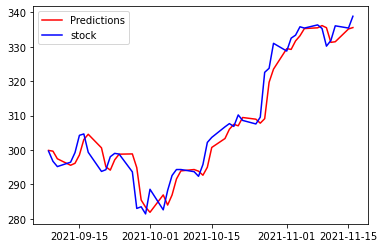

In [17]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

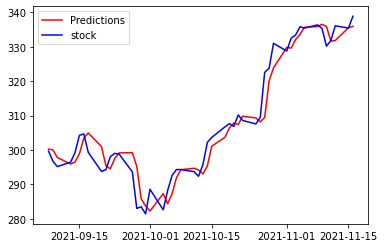

In [18]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

In [19]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

1.0359629006491031
39.57453578411442
1.018074107423186


In [20]:
stock = web.get_data_yahoo("GOOGL",
start = "2019-01-01",
end = "2021-11-17")
y=stock['Adj Close']

Y_t=y.T
Y_t=Y_t.iloc[1:727]
Y_train=Y_t

model = pm.auto_arima(Y_train, start_p=3, start_q=3,start_d=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, max_d=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      #start_P=0, 
                      #D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

#ARIMA model
Errors_000=[]
predds=list()
n=675
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=model.order)
    arima_model_fit = arima_model.fit()
    preds_arima= arima_model_fit.forecast(len(Y_test),alpha=0.3)
    preds_arima=np.array(preds_arima)
    preds_atempt_1=preds_arima
    preds = pd.Series(preds_arima, index=Y_test.index)
    
    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    predds.append(preds_atempt_1)

    Error_i = ([mse, rmse, mae, mape])
    Errors_000.append(Error_i)
    Errors_A=pd.DataFrame(Errors_000)




#Garch model   
Errors_001=[]

for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]

    garch = arch_model(Y_train, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    preds = pd.DataFrame([garch_pred_mean])

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_001.append(Error_i)
    Errors_B=pd.DataFrame(Errors_001)

    
#ARIMA-GARCH model  
Errors_002=[]
predds_0=list()
for i in range(0,50):
    Y_train=Y_t.iloc[:n+i]
    Y_test=Y_t.iloc[n+i:n+1+i]
    
    arima_model = ARIMA(Y_train, order=(model.order))
    arima_model_fit = arima_model.fit()
    arima_residuals = arima_model_fit.resid
    predicted_mu = arima_model_fit.forecast(len(Y_test))
    garch = arch_model(arima_residuals, vol="Garch", p=1, q=1, dist="gaussian")
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1)
    garch_pred_mean = garch_forecast.mean['h.1'].iloc[-1]
    garch_pred_var = garch_forecast.variance['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    preds = predicted_mu + garch_pred_mean
    preds_0=np.array(preds)
    predds_0.append(preds_0)

    mse = mean_squared_error(Y_test, preds)
    rmse = sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    mape=MAPE(Y_test, preds)
    Error_i = ([mse, rmse, mae, mape])
    Errors_002.append(Error_i)
    Errors_C=pd.DataFrame(Errors_002)
    
    
# print(Errors_A[3].mean())
# print(Errors_B[3].mean())
# print(Errors_C[3].mean())

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6941.293, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6964.352, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6956.646, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6957.000, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6968.302, Time=0.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6959.613, Time=0.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6951.273, Time=0.87 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6959.597, Time=0.61 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=6961.613, Time=0.95 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6959.876, Time=1.02 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=6935.303, Time=1.20 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=6937.207, Time=1.34 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604:

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20341.722323883972
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4807.29045551798
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4797.646098605217
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4749.080797550714
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4645.358824252474
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4633.869893786588
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4763.626157783188
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5902.296674542584
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4625.668320251656
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4613.69512256123
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4613.4633117781295
Iteration:     12,   Func. Count:     67,   Neg. LLF: 4612.847628016805
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4612.837673886319
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4612.83732

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.342e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      2,   Func. Count:     13,   Neg. LLF: 4829.872239102453
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4820.419947759567
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4772.111805371034
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4663.687819257155
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4652.330814507772
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4771.685996169778
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5909.704985424831
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4643.273926269696
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4632.202245998011
Iteration:     11,   Func. Count:     62,   Neg. LLF: 4631.961077000167
Iteration:     12,   Func. Count:     67,   Neg. LLF: 4631.33738761348
Iteration:     13,   Func. Count:     72,   Neg. LLF: 4631.314775316761
Iteration:     14,   Func. Count:     77,   Neg. LLF: 4631.31343545132
Iteration:     15,   Func. Count:     82,   Neg. LLF: 4631.3133351

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.381e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     42,   Func. Count:    230,   Neg. LLF: 4598.491400558722
Iteration:     43,   Func. Count:    235,   Neg. LLF: 4598.4906206798305
Iteration:     44,   Func. Count:    240,   Neg. LLF: 4598.49046937784
Iteration:     45,   Func. Count:    244,   Neg. LLF: 4598.490469200168
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4598.49046937784
            Iterations: 45
            Function evaluations: 244
            Gradient evaluations: 45
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20540.153375514223
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4874.413507301491
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4865.435215707908
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4818.32656604037
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4700.785462793105
Iteration:      6,   Func. Count:     33,   Neg. LLF: 4689.661341163299
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4781.682313188752

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.422e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     44,   Func. Count:    243,   Neg. LLF: 4618.469472379965
Iteration:     45,   Func. Count:    248,   Neg. LLF: 4618.215827833185
Iteration:     46,   Func. Count:    253,   Neg. LLF: 4618.04651024296
Iteration:     47,   Func. Count:    258,   Neg. LLF: 4617.896357560996
Iteration:     48,   Func. Count:    263,   Neg. LLF: 4617.102557569053
Iteration:     49,   Func. Count:    268,   Neg. LLF: 4627.27565568698
Iteration:     50,   Func. Count:    274,   Neg. LLF: 4616.752037237238
Iteration:     51,   Func. Count:    280,   Neg. LLF: 4616.206300503729
Iteration:     52,   Func. Count:    285,   Neg. LLF: 4616.195694079213
Iteration:     53,   Func. Count:    290,   Neg. LLF: 4616.194044484459
Iteration:     54,   Func. Count:    295,   Neg. LLF: 4616.19387376462
Iteration:     55,   Func. Count:    300,   Neg. LLF: 4616.193861239223
Iteration:     56,   Func. Count:    304,   Neg. LLF: 4616.193861061295
Optimization terminated successfully    (Exit mode 0)
            C

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.46e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     35,   Func. Count:    190,   Neg. LLF: 4663.084229631886
Iteration:     36,   Func. Count:    196,   Neg. LLF: 4675.413394575532
Iteration:     37,   Func. Count:    202,   Neg. LLF: 4829.926069567818
Iteration:     38,   Func. Count:    208,   Neg. LLF: 4808.588477517305
Iteration:     39,   Func. Count:    214,   Neg. LLF: 4785.751669335704
Iteration:     40,   Func. Count:    220,   Neg. LLF: 4750.41655889633
Iteration:     41,   Func. Count:    226,   Neg. LLF: 4722.555854870881
Iteration:     42,   Func. Count:    232,   Neg. LLF: 4709.213365278795
Iteration:     43,   Func. Count:    238,   Neg. LLF: 4642.749210912278
Iteration:     44,   Func. Count:    244,   Neg. LLF: 4636.732717624092
Iteration:     45,   Func. Count:    250,   Neg. LLF: 4636.302819572065
Iteration:     46,   Func. Count:    255,   Neg. LLF: 4635.070177531501
Iteration:     47,   Func. Count:    260,   Neg. LLF: 4666.055146273753
Iteration:     48,   Func. Count:    266,   Neg. LLF: 4636.306736

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.494e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     38,   Func. Count:    207,   Neg. LLF: 4705.6409950250145
Iteration:     39,   Func. Count:    213,   Neg. LLF: 4862.8514954022885
Iteration:     40,   Func. Count:    219,   Neg. LLF: 4725.322582393653
Iteration:     41,   Func. Count:    225,   Neg. LLF: 4740.503077650947
Iteration:     42,   Func. Count:    231,   Neg. LLF: 4705.853120794498
Iteration:     43,   Func. Count:    237,   Neg. LLF: 4696.663205058072
Iteration:     44,   Func. Count:    243,   Neg. LLF: 4694.932719865934
Iteration:     45,   Func. Count:    249,   Neg. LLF: 4693.584480447616
Iteration:     46,   Func. Count:    255,   Neg. LLF: 4691.983325419184
Iteration:     47,   Func. Count:    261,   Neg. LLF: 4660.931110531992
Iteration:     48,   Func. Count:    267,   Neg. LLF: 4653.729284823689
Iteration:     49,   Func. Count:    272,   Neg. LLF: 4653.354504476614
Iteration:     50,   Func. Count:    277,   Neg. LLF: 4653.2137713851425
Iteration:     51,   Func. Count:    282,   Neg. LLF: 4652.78

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.529e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     30,   Func. Count:    158,   Neg. LLF: 4913.200865748484
Iteration:     31,   Func. Count:    164,   Neg. LLF: 4733.282205851186
Iteration:     32,   Func. Count:    170,   Neg. LLF: 4778.620965892589
Iteration:     33,   Func. Count:    176,   Neg. LLF: 4710.495594208996
Iteration:     34,   Func. Count:    182,   Neg. LLF: 4712.3509731870045
Iteration:     35,   Func. Count:    188,   Neg. LLF: 4698.934848524991
Iteration:     36,   Func. Count:    194,   Neg. LLF: 4705.755906109542
Iteration:     37,   Func. Count:    200,   Neg. LLF: 4716.044761214031
Iteration:     38,   Func. Count:    206,   Neg. LLF: 4709.494040268916
Iteration:     39,   Func. Count:    212,   Neg. LLF: 4699.297441383613
Iteration:     40,   Func. Count:    218,   Neg. LLF: 4672.30081472366
Iteration:     41,   Func. Count:    224,   Neg. LLF: 4669.940635478929
Iteration:     42,   Func. Count:    229,   Neg. LLF: 4669.391116771307
Iteration:     43,   Func. Count:    234,   Neg. LLF: 4670.97185

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.566e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     27,   Func. Count:    146,   Neg. LLF: 6234.640774076482
Iteration:     28,   Func. Count:    152,   Neg. LLF: 4707.512116726071
Iteration:     29,   Func. Count:    157,   Neg. LLF: 5413.2797918822625
Iteration:     30,   Func. Count:    163,   Neg. LLF: 4964.086189912647
Iteration:     31,   Func. Count:    169,   Neg. LLF: 4836.824295695178
Iteration:     32,   Func. Count:    175,   Neg. LLF: 4772.760151965251
Iteration:     33,   Func. Count:    181,   Neg. LLF: 46315.26099490228
Iteration:     34,   Func. Count:    188,   Neg. LLF: 4710.543037602731
Iteration:     35,   Func. Count:    194,   Neg. LLF: 4697.398708078191
Iteration:     36,   Func. Count:    200,   Neg. LLF: 4694.372588626674
Iteration:     37,   Func. Count:    205,   Neg. LLF: 4694.318133357267
Iteration:     38,   Func. Count:    210,   Neg. LLF: 4694.271173775589
Iteration:     39,   Func. Count:    215,   Neg. LLF: 4694.020453203144
Iteration:     40,   Func. Count:    220,   Neg. LLF: 4692.9318

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.593e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     29,   Func. Count:    155,   Neg. LLF: 6087.18736430949
Iteration:     30,   Func. Count:    161,   Neg. LLF: 4972.565388924369
Iteration:     31,   Func. Count:    167,   Neg. LLF: 4880.339584553243
Iteration:     32,   Func. Count:    173,   Neg. LLF: 4770.375290179672
Iteration:     33,   Func. Count:    179,   Neg. LLF: 4793.349892233865
Iteration:     34,   Func. Count:    185,   Neg. LLF: 4873.478721616773
Iteration:     35,   Func. Count:    191,   Neg. LLF: 4766.885600433123
Iteration:     36,   Func. Count:    197,   Neg. LLF: 4755.995434665288
Iteration:     37,   Func. Count:    203,   Neg. LLF: 4753.910292398353
Iteration:     38,   Func. Count:    209,   Neg. LLF: 4752.509954015556
Iteration:     39,   Func. Count:    215,   Neg. LLF: 4730.232213417585
Iteration:     40,   Func. Count:    221,   Neg. LLF: 4706.075850090056
Iteration:     41,   Func. Count:    226,   Neg. LLF: 4783.902334393539
Iteration:     42,   Func. Count:    232,   Neg. LLF: 4707.287124

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.62e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     34,   Func. Count:    178,   Neg. LLF: 4723.807237041445
Iteration:     35,   Func. Count:    183,   Neg. LLF: 4723.065639495146
Iteration:     36,   Func. Count:    188,   Neg. LLF: 4721.8964034121655
Iteration:     37,   Func. Count:    193,   Neg. LLF: 4722.1229037231105
Iteration:     38,   Func. Count:    199,   Neg. LLF: 4721.5877138219375
Iteration:     39,   Func. Count:    205,   Neg. LLF: 4721.522087849016
Iteration:     40,   Func. Count:    210,   Neg. LLF: 4721.520169552141
Iteration:     41,   Func. Count:    215,   Neg. LLF: 4721.520173516624
Iteration:     42,   Func. Count:    220,   Neg. LLF: 4721.520166511965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4721.520166681487
            Iterations: 42
            Function evaluations: 220
            Gradient evaluations: 42
Iteration:      1,   Func. Count:      6,   Neg. LLF: 20993.20087409758
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5023.23907900

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.661e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     49,   Func. Count:    268,   Neg. LLF: 4739.254148001297
Iteration:     50,   Func. Count:    274,   Neg. LLF: 4739.041285963222
Iteration:     51,   Func. Count:    279,   Neg. LLF: 4739.040415124249
Iteration:     52,   Func. Count:    284,   Neg. LLF: 4739.039393589415
Iteration:     53,   Func. Count:    289,   Neg. LLF: 4739.039327644611
Iteration:     54,   Func. Count:    293,   Neg. LLF: 4739.039327474326
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4739.039327644611
            Iterations: 54
            Function evaluations: 293
            Gradient evaluations: 54
Iteration:      1,   Func. Count:      6,   Neg. LLF: 21057.588547482173
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5044.059408946679
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5037.781094537362
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5003.014949772984
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4856.0289593059

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.692e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     39,   Func. Count:    210,   Neg. LLF: 4800.724228601214
Iteration:     40,   Func. Count:    216,   Neg. LLF: 4794.022051153957
Iteration:     41,   Func. Count:    222,   Neg. LLF: 4793.067872263856
Iteration:     42,   Func. Count:    228,   Neg. LLF: 4792.426094175009
Iteration:     43,   Func. Count:    234,   Neg. LLF: 4790.154991486804
Iteration:     44,   Func. Count:    240,   Neg. LLF: 4762.976226315741
Iteration:     45,   Func. Count:    246,   Neg. LLF: 4757.615568002615
Iteration:     46,   Func. Count:    251,   Neg. LLF: 4757.089934010701
Iteration:     47,   Func. Count:    256,   Neg. LLF: 4761.5231102306125
Iteration:     48,   Func. Count:    262,   Neg. LLF: 4756.714593815121
Iteration:     49,   Func. Count:    267,   Neg. LLF: 4756.662066776869
Iteration:     50,   Func. Count:    272,   Neg. LLF: 4756.630787852244
Iteration:     51,   Func. Count:    277,   Neg. LLF: 4756.629772991658
Iteration:     52,   Func. Count:    282,   Neg. LLF: 4756.6297

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.721e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     30,   Func. Count:    158,   Neg. LLF: 6314.370989213692
Iteration:     31,   Func. Count:    164,   Neg. LLF: 4868.240907071479
Iteration:     32,   Func. Count:    170,   Neg. LLF: 5077.029306790464
Iteration:     33,   Func. Count:    176,   Neg. LLF: 4863.916104771029
Iteration:     34,   Func. Count:    182,   Neg. LLF: 4847.534851785449
Iteration:     35,   Func. Count:    188,   Neg. LLF: 5689.170331319099
Iteration:     36,   Func. Count:    194,   Neg. LLF: 5088.850013957073
Iteration:     37,   Func. Count:    200,   Neg. LLF: 4792.61590310419
Iteration:     38,   Func. Count:    206,   Neg. LLF: 4795.585387285211
Iteration:     39,   Func. Count:    212,   Neg. LLF: 4797.174043836544
Iteration:     40,   Func. Count:    218,   Neg. LLF: 4795.768744430876
Iteration:     41,   Func. Count:    224,   Neg. LLF: 4794.054619615838
Iteration:     42,   Func. Count:    230,   Neg. LLF: 4792.4759697270265
Iteration:     43,   Func. Count:    236,   Neg. LLF: 4778.09096

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.752e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     17,   Func. Count:     89,   Neg. LLF: 4858.100785626691
Iteration:     18,   Func. Count:     94,   Neg. LLF: 4858.0786971929465
Iteration:     19,   Func. Count:     99,   Neg. LLF: 4858.019948339258
Iteration:     20,   Func. Count:    104,   Neg. LLF: 4857.848347900519
Iteration:     21,   Func. Count:    109,   Neg. LLF: 4857.4026954115825
Iteration:     22,   Func. Count:    114,   Neg. LLF: 4856.1796005217075
Iteration:     23,   Func. Count:    119,   Neg. LLF: 4852.731710006695
Iteration:     24,   Func. Count:    124,   Neg. LLF: 4842.479683177117
Iteration:     25,   Func. Count:    129,   Neg. LLF: 5665.226885733055
Iteration:     26,   Func. Count:    135,   Neg. LLF: 5608.65790057903
Iteration:     27,   Func. Count:    141,   Neg. LLF: 5016.353003445536
Iteration:     28,   Func. Count:    147,   Neg. LLF: 4882.549526189651
Iteration:     29,   Func. Count:    153,   Neg. LLF: 4843.483766246083
Iteration:     30,   Func. Count:    159,   Neg. LLF: 4868.565

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.786e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     14,   Func. Count:     74,   Neg. LLF: 4876.3266117343865
Iteration:     15,   Func. Count:     79,   Neg. LLF: 4876.326227805942
Iteration:     16,   Func. Count:     84,   Neg. LLF: 4876.325570400499
Iteration:     17,   Func. Count:     89,   Neg. LLF: 4876.322106025749
Iteration:     18,   Func. Count:     94,   Neg. LLF: 4876.314755980669
Iteration:     19,   Func. Count:     99,   Neg. LLF: 4876.294745406399
Iteration:     20,   Func. Count:    104,   Neg. LLF: 4876.241124623326
Iteration:     21,   Func. Count:    109,   Neg. LLF: 4876.094165827781
Iteration:     22,   Func. Count:    114,   Neg. LLF: 4875.741157317478
Iteration:     23,   Func. Count:    119,   Neg. LLF: 4874.8798309861195
Iteration:     24,   Func. Count:    124,   Neg. LLF: 4872.273785718305
Iteration:     25,   Func. Count:    129,   Neg. LLF: 4866.600743792145
Iteration:     26,   Func. Count:    134,   Neg. LLF: 5303.268274500386
Iteration:     27,   Func. Count:    140,   Neg. LLF: 5908.706

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.82e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      6,   Func. Count:     33,   Neg. LLF: 4896.697454372216
Iteration:      7,   Func. Count:     38,   Neg. LLF: 4897.660090124132
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4896.088343497411
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4895.111180429771
Iteration:     10,   Func. Count:     54,   Neg. LLF: 4894.577553819767
Iteration:     11,   Func. Count:     59,   Neg. LLF: 4894.540995136853
Iteration:     12,   Func. Count:     64,   Neg. LLF: 4894.540277839539
Iteration:     13,   Func. Count:     69,   Neg. LLF: 4894.540191471306
Iteration:     14,   Func. Count:     74,   Neg. LLF: 4894.53962849812
Iteration:     15,   Func. Count:     79,   Neg. LLF: 4894.536238432814
Iteration:     16,   Func. Count:     84,   Neg. LLF: 4894.5189154636555
Iteration:     17,   Func. Count:     89,   Neg. LLF: 4894.487412573467
Iteration:     18,   Func. Count:     94,   Neg. LLF: 4894.412796412999
Iteration:     19,   Func. Count:     99,   Neg. LLF: 4894.15319

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.85e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      6,   Func. Count:     33,   Neg. LLF: 5011.444736089919
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4915.945453715016
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5005.943302137408
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4914.01688787167
Iteration:     10,   Func. Count:     55,   Neg. LLF: 4913.793758933341
Iteration:     11,   Func. Count:     60,   Neg. LLF: 4912.933169591078
Iteration:     12,   Func. Count:     65,   Neg. LLF: 4912.618871134982
Iteration:     13,   Func. Count:     70,   Neg. LLF: 4912.604402097822
Iteration:     14,   Func. Count:     75,   Neg. LLF: 4912.604196130901
Iteration:     15,   Func. Count:     80,   Neg. LLF: 4912.6040854421735
Iteration:     16,   Func. Count:     85,   Neg. LLF: 4912.603471321724
Iteration:     17,   Func. Count:     90,   Neg. LLF: 4912.602030735559
Iteration:     18,   Func. Count:     95,   Neg. LLF: 4912.598386668309
Iteration:     19,   Func. Count:    100,   Neg. LLF: 4912.58796

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.878e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21476.079232841847
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5177.75924839465
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5173.891142766885
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5152.571025317842
Iteration:      5,   Func. Count:     28,   Neg. LLF: 5017.780301812569
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5302.890076694754
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4943.009411398461
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5184.280856816431
Iteration:      9,   Func. Count:     50,   Neg. LLF: 5484.437584931418
Iteration:     10,   Func. Count:     56,   Neg. LLF: 4931.945775658212
Iteration:     11,   Func. Count:     61,   Neg. LLF: 4931.608629715771
Iteration:     12,   Func. Count:     66,   Neg. LLF: 4930.655679099811
Iteration:     13,   Func. Count:     71,   Neg. LLF: 4930.602050739144
Iteration:     14,   Func. Count:     76,   Neg. LLF: 4930.60037

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.916e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     40,   Func. Count:    211,   Neg. LLF: 4921.545770022856
Iteration:     41,   Func. Count:    216,   Neg. LLF: 4921.413128192805
Iteration:     42,   Func. Count:    221,   Neg. LLF: 4921.089858538367
Iteration:     43,   Func. Count:    226,   Neg. LLF: 4920.235682490876
Iteration:     44,   Func. Count:    231,   Neg. LLF: 4918.026367318402
Iteration:     45,   Func. Count:    236,   Neg. LLF: 42745.30914599297
Iteration:     46,   Func. Count:    243,   Neg. LLF: 5127.414311270721
Iteration:     47,   Func. Count:    249,   Neg. LLF: 5016.895495518627
Iteration:     48,   Func. Count:    255,   Neg. LLF: 5249.322751368243
Iteration:     49,   Func. Count:    261,   Neg. LLF: 5777.962186423711
Iteration:     50,   Func. Count:    267,   Neg. LLF: 4951.905549316942
Iteration:     51,   Func. Count:    273,   Neg. LLF: 4950.933117397439
Iteration:     52,   Func. Count:    279,   Neg. LLF: 5082.490561360073
Iteration:     53,   Func. Count:    285,   Neg. LLF: 6877.03475

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.953e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:      8,   Func. Count:     44,   Neg. LLF: 5156.7362996326865
Iteration:      9,   Func. Count:     50,   Neg. LLF: 5634.165574489325
Iteration:     10,   Func. Count:     56,   Neg. LLF: 4977.757019434614
Iteration:     11,   Func. Count:     61,   Neg. LLF: 4977.3074074964115
Iteration:     12,   Func. Count:     66,   Neg. LLF: 4976.511722366189
Iteration:     13,   Func. Count:     71,   Neg. LLF: 4976.456755177534
Iteration:     14,   Func. Count:     76,   Neg. LLF: 4976.450163710376
Iteration:     15,   Func. Count:     81,   Neg. LLF: 4976.450064248098
Iteration:     16,   Func. Count:     86,   Neg. LLF: 4976.449858972441
Iteration:     17,   Func. Count:     91,   Neg. LLF: 4976.449230848286
Iteration:     18,   Func. Count:     96,   Neg. LLF: 4976.447773625056
Iteration:     19,   Func. Count:    101,   Neg. LLF: 4976.443712453847
Iteration:     20,   Func. Count:    106,   Neg. LLF: 4976.43220951843
Iteration:     21,   Func. Count:    111,   Neg. LLF: 4976.4049

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.99e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21703.827641829997
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5249.843723283724
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5247.01101327287
Iteration:      4,   Func. Count:     23,   Neg. LLF: 5231.5080348804295
Iteration:      5,   Func. Count:     28,   Neg. LLF: 5123.7874951157555
Iteration:      6,   Func. Count:     33,   Neg. LLF: 5432.102065057987
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5007.325747414952
Iteration:      8,   Func. Count:     44,   Neg. LLF: 5162.815296276711
Iteration:      9,   Func. Count:     50,   Neg. LLF: 5713.892281653931
Iteration:     10,   Func. Count:     56,   Neg. LLF: 4996.2160686430525
Iteration:     11,   Func. Count:     61,   Neg. LLF: 4995.959973752175
Iteration:     12,   Func. Count:     66,   Neg. LLF: 4995.226512835161
Iteration:     13,   Func. Count:     71,   Neg. LLF: 4994.92848229041
Iteration:     14,   Func. Count:     76,   Neg. LLF: 4994.843

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.03e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     52,   Func. Count:    282,   Neg. LLF: 4946.293338518561
Iteration:     53,   Func. Count:    287,   Neg. LLF: 4946.1977443228125
Iteration:     54,   Func. Count:    292,   Neg. LLF: 4945.9082046608455
Iteration:     55,   Func. Count:    297,   Neg. LLF: 4945.200234256543
Iteration:     56,   Func. Count:    302,   Neg. LLF: 4942.716166767354
Iteration:     57,   Func. Count:    307,   Neg. LLF: 4961.658655882963
Iteration:     58,   Func. Count:    313,   Neg. LLF: 5022.483477023441
Iteration:     59,   Func. Count:    319,   Neg. LLF: 4972.836041926366
Iteration:     60,   Func. Count:    325,   Neg. LLF: 4970.756379750632
Iteration:     61,   Func. Count:    331,   Neg. LLF: 4944.6057269732955
Iteration:     62,   Func. Count:    337,   Neg. LLF: 4934.975848472393
Iteration:     63,   Func. Count:    342,   Neg. LLF: 4934.365280159276
Iteration:     64,   Func. Count:    347,   Neg. LLF: 4934.273584659481
Iteration:     65,   Func. Count:    353,   Neg. LLF: 4933.66

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.07e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this 

Iteration:     25,   Func. Count:    131,   Neg. LLF: 5022.081464436396
Iteration:     26,   Func. Count:    136,   Neg. LLF: 5021.449587971274
Iteration:     27,   Func. Count:    141,   Neg. LLF: 5019.919802753033
Iteration:     28,   Func. Count:    146,   Neg. LLF: 5014.543446520262
Iteration:     29,   Func. Count:    151,   Neg. LLF: 5004.235543832504
Iteration:     30,   Func. Count:    156,   Neg. LLF: 5086.275930728127
Iteration:     31,   Func. Count:    162,   Neg. LLF: 5002.121123308917
Iteration:     32,   Func. Count:    167,   Neg. LLF: 5000.982559422428
Iteration:     33,   Func. Count:    172,   Neg. LLF: 5884.068918875385
Iteration:     34,   Func. Count:    179,   Neg. LLF: 4998.969318759408
Iteration:     35,   Func. Count:    185,   Neg. LLF: 4996.724973720329
Iteration:     36,   Func. Count:    190,   Neg. LLF: 4990.535570524443
Iteration:     37,   Func. Count:    195,   Neg. LLF: 5055.926061809605
Iteration:     38,   Func. Count:    201,   Neg. LLF: 5154.91412

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.105e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this

Iteration:     10,   Func. Count:     56,   Neg. LLF: 5042.177218060237
Iteration:     11,   Func. Count:     61,   Neg. LLF: 5041.869740089114
Iteration:     12,   Func. Count:     66,   Neg. LLF: 5041.17239740888
Iteration:     13,   Func. Count:     71,   Neg. LLF: 5040.837601732326
Iteration:     14,   Func. Count:     76,   Neg. LLF: 5040.780276513185
Iteration:     15,   Func. Count:     81,   Neg. LLF: 5040.77061100108
Iteration:     16,   Func. Count:     86,   Neg. LLF: 5040.770533207321
Iteration:     17,   Func. Count:     91,   Neg. LLF: 5040.770180772408
Iteration:     18,   Func. Count:     96,   Neg. LLF: 5040.769275987649
Iteration:     19,   Func. Count:    101,   Neg. LLF: 5040.767207792446
Iteration:     20,   Func. Count:    106,   Neg. LLF: 5040.761717614627
Iteration:     21,   Func. Count:    111,   Neg. LLF: 5040.746360387298
Iteration:     22,   Func. Count:    116,   Neg. LLF: 5040.708861125312
Iteration:     23,   Func. Count:    121,   Neg. LLF: 5040.6041419

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.143e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but

Iteration:     12,   Func. Count:     66,   Neg. LLF: 5059.996289250206
Iteration:     13,   Func. Count:     71,   Neg. LLF: 5059.278466248333
Iteration:     14,   Func. Count:     76,   Neg. LLF: 5059.190093988124
Iteration:     15,   Func. Count:     81,   Neg. LLF: 5059.167406968716
Iteration:     16,   Func. Count:     86,   Neg. LLF: 5059.167272287615
Iteration:     17,   Func. Count:     91,   Neg. LLF: 5059.167167316677
Iteration:     18,   Func. Count:     96,   Neg. LLF: 5059.166537075813
Iteration:     19,   Func. Count:    101,   Neg. LLF: 5059.163110081367
Iteration:     20,   Func. Count:    106,   Neg. LLF: 5059.144458328862
Iteration:     21,   Func. Count:    111,   Neg. LLF: 5059.092002991802
Iteration:     22,   Func. Count:    116,   Neg. LLF: 5059.001532062585
Iteration:     23,   Func. Count:    121,   Neg. LLF: 5058.750009299219
Iteration:     24,   Func. Count:    126,   Neg. LLF: 5058.053852521888
Iteration:     25,   Func. Count:    131,   Neg. LLF: 5056.36062

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18823.72221978382
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3286.969762054194
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3188.321881899443
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3200.5804149752894
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3186.35007856076
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3184.4710938426797
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3179.928954773467
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3177.0310349082374
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3175.2908221619728
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3174.93617564579
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3174.883824135774
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3174.8600988516664
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3174.85158576527
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3174.849

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18852.84318905033
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3300.6609218875215
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3189.9769821528766
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3207.2724157446173
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3188.077807938054
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3186.427825878566
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3183.0215285171603
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3180.0902609329805
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3177.6020414314394
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3176.7394407968277
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3176.66494572954
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3176.6467057227937
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3176.6368698599063
Iteration:     14,   Func. Count:     76,   Neg. LLF: 31

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18870.638123980592
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3300.3124630181146
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3195.709462737628
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3205.8704471900064
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3194.206452538695
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3192.1587515381643
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3187.1178942016186
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3184.063656818446
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3182.2236012339663
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3181.898700871073
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3181.8350641498096
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3181.798968368461
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3181.791719443173
Iteration:     14,   Func. Count:     76,   Neg. LLF: 318

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18885.821761925516
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3313.950914804491
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3400.4730103745887
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3202.177305627705
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3199.1742478310402
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3197.5167314669848
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3192.5594496074687
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3189.322683475184
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3187.6449054080053
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3187.088861490472
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3186.975272343118
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3186.937291496646
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3186.9271620719765
Iteration:     14,   Func. Count:     77,   Neg. LLF: 318

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18915.258094500095
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3329.422498399389
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3405.4783178819575
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3208.671316129987
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3203.8393176723707
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3202.3272357306796
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3197.623358041065
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3194.1991392458135
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3192.475777787964
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3191.85370317696
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3191.730078576084
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3191.691298754272
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3191.680423758389
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3191.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18942.160153691217
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3337.2102164629346
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3410.0801939447797
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3213.6867050903966
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3208.155480363298
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3206.624847510472
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3201.8705009084197
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3198.4213630702875
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3196.6760641591563
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3196.0464830702927
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3195.9206145926178
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3195.8810646267284
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3195.8697736171584
Iteration:     14,   Func. Count:     77,   Neg. LLF:

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18973.369834743375
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3355.5677927681877
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3415.0587613481375
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3222.99254015741
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3212.887203556867
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3211.5367160974383
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3207.137989437312
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3203.464734036505
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3201.671318959885
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3200.973472895257
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3200.833368889024
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3200.7917736218055
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3200.7797956472923
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3200.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19003.16377459965
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3354.1855987664103
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3420.67388237913
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3224.6441742315283
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3217.263298281461
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3215.9216169622205
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3211.5733293643075
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3208.0099312945104
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3206.287864422751
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3205.620106022011
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3205.4889562865465
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3205.4513383190324
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3205.4404581332988
Iteration:     14,   Func. Count:     77,   Neg. LLF: 320

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19047.486323753063
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3389.6885698697624
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3225.516986839967
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3538.429202004301
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3224.39125814802
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3223.3823240380516
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3222.086494746958
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3218.845264960312
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3215.7185841126834
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3213.679095957244
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3213.2457764104297
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3213.2248027479495
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3213.2203312144293
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3213

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19074.18411311908
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3377.3340645687263
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3230.5584978653224
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3276.6825934411963
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3229.401796287733
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3228.245088231955
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3226.652357908836
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3223.4549806211126
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3220.3746579774865
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3218.5146490909347
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3218.1961693172916
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3218.180940715311
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3218.1767943248224
Iteration:     14,   Func. Count:     77,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19093.13540562936
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3398.8610133351795
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3234.7899547205457
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3411.7960903665353
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3233.936842462801
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3232.8042988562684
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3231.2164513009857
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3228.0858940976714
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3224.9291567333
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3222.932031006985
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3222.5006214293644
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3222.4746425541125
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3222.469877893373
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3222

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19116.40618376407
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3414.6309929977833
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3239.3707008144434
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3561.9053939078094
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3238.532163239243
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3237.2763774567948
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3235.044149237543
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3231.9197568726686
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3228.617040648789
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3226.7010498013287
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3226.368310119651
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3226.342154739183
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3226.3367483925595
Iteration:     14,   Func. Count:     77,   Neg. LLF: 322

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19144.826514770426
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3441.878937034812
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3244.114332063563
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3542.357612506463
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3243.293903541372
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3242.072606001404
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3239.993697977171
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3236.8569880825653
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3233.457706590434
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3231.391367213935
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3230.9909604348018
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3230.9571102203336
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3230.950995892962
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3230.9

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19175.28537207428
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3465.9455048802265
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3247.847520921104
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3496.920142471062
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3247.144656279527
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3246.8324949325734
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3246.491112275784
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3244.616625741689
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3239.286061815128
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3236.5830263278485
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3235.2548757579834
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3234.866269458714
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3234.7273366623085
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3234.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19201.662953041112
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3461.0031154520375
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3252.583682244354
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3505.3927162883374
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3251.875962187753
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3251.570974960149
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3251.2142053531097
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3249.334222484071
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3244.0186283973953
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3241.269795479696
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3239.9393020671587
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3239.556857020808
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3239.4235800255665
Iteration:     14,   Func. Count:     75,   Neg. LLF: 323

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19215.216487966914
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3411.8407295028487
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3265.4552568819154
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3318.992753795633
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3264.7427705427804
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3263.6076346001255
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3262.1565840710937
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3258.975970605574
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3256.136641088458
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3254.3840558705697
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3253.9203654562475
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3253.888561171674
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3253.88352381557
Iteration:     14,   Func. Count:     77,   Neg. LLF: 325

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19238.90953368562
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3402.006332560323
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3270.9398746445804
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3295.886673038488
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3270.1738631384733
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3268.820981455185
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3266.259505196578
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3263.361447105258
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3260.7534570587604
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3259.3671238453735
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3259.103595250551
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3259.0874719123367
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3259.083395933829
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3259.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19265.949531104878
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3403.136260445123
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3276.0467527223723
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3305.1774927429497
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3275.1902774615755
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3274.34007460038
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3272.893054770962
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3270.286166665571
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3267.2765972144625
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3264.9626973261106
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3264.2105490587564
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3264.1283851681874
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3264.1110218949325
Iteration:     14,   Func. Count:     76,   Neg. LLF: 32

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19296.954251326177
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3431.8875010642964
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3280.91934285339
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3420.640194286597
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3280.1286759140744
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3278.9522259647265
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3277.263681850952
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3274.2133127910593
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3271.3834348537507
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3269.653161751481
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3269.1590623626234
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3269.127860753764
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3269.123309295453
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3269

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19321.76985511947
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3409.478918231128
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3286.510014820199
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3307.808643457885
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3285.6418102192997
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3284.5756765359956
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3283.0035348614538
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3280.1505870036617
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3277.2470403293864
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3275.2742619153787
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3274.7594097922038
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3274.7092654846692
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3274.6979882003475
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19350.231906642482
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3426.704457337062
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3291.721668495962
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3337.945177904029
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3290.855044359391
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3289.532661409951
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3287.2219179111457
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3284.2962696018026
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3281.658511862802
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3280.1743440030396
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3279.837895984579
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3279.8205223094283
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3279.816392950671
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3279.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19379.53336761373
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3449.8820656199186
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3296.6215711484588
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3537.3603663434715
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3295.782828996105
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3294.5955273075297
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3292.944944887726
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3289.8066300757755
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3286.9616948021894
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3285.209415710738
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3284.710974930169
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3284.6802654851194
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3284.675445954911
Iteration:     14,   Func. Count:     77,   Neg. LLF: 328

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19409.446435790524
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3466.3534260895403
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3301.4903006562113
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3628.7785015487516
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3300.647344328596
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3299.5716547817165
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3298.2346768456264
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3294.947564857782
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3292.071968030701
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3290.2359961726993
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3289.6643101538216
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3289.6233703976486
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3289.6180087179187
Iteration:     14,   Func. Count:     77,   Neg. LLF: 

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19437.10035146836
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3472.51958371834
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3306.350035235985
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3628.044767742984
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3305.4661959283003
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3304.3838433414967
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3303.0308154700483
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3299.739842675137
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3296.8548761701286
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3295.0062524051737
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3294.416853161054
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3294.3751499044183
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3294.3695550627262
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3294

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19454.83526124439
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3431.6117375728863
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3312.6300562212455
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3397.546446799608
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3310.8942595451854
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3310.2500393433056
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3308.789585656774
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3306.5465444228985
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3303.659624355965
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3301.3847657053384
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3300.6031874697583
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3300.4705413795436
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3300.4365327638216
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19479.10050901328
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3423.627753130638
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3318.6498926479308
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3354.9413413721786
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3316.7893155263023
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3315.0629773506616
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3313.0986529907887
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3310.4171592976736
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3308.2503957582376
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3307.345562583416
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3307.1596129791187
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3307.1215557887917
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3307.110266816252
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19507.39539049563
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3436.9257704039323
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3323.3917519711986
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3386.2365602732098
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3321.514039811238
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3320.7195751185077
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3319.212689848906
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3316.89875701047
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3314.1960472047394
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3312.3996848798683
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3311.8930618365484
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3311.7947955620084
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3311.7650179493485
Iteration:     14,   Func. Count:     76,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19536.652147608722
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3457.1812411833744
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3329.209488267284
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3590.52110100509
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3327.5221725739057
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3326.1028116086122
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3322.077773981696
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3319.8268492799043
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3318.2871316031883
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3317.6905816541944
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3317.591428939997
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3317.5847960312476
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3317.5818018326536
Iteration:     14,   Func. Count:     77,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19563.763893428037
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3458.0112045351925
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3333.843575675889
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3496.7744460042786
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3332.1148165357254
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3330.652529232566
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3326.267878531131
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3324.0916022388865
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3322.657205178506
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3322.133494170702
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3322.0520841634443
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3322.0449217717533
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3322.0407410170424
Iteration:     14,   Func. Count:     77,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19607.846311674453
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3510.37284171636
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3336.693005377635
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3656.3728651196298
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3335.7207875283334
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3334.945248685887
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3333.8743951465967
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3331.2663419262253
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3328.5715982394345
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3326.7529572658113
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3325.9751236566544
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3325.8722750945863
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3325.8675925491407
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19618.749698196683
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3470.9727176557462
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3342.899207532693
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3573.4397764230093
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3341.0426638376475
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3339.576382625083
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3335.03157391447
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3332.656970588644
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3331.255503340438
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3330.7326439881817
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3330.644576384976
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3330.631880178631
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3330.625096577114
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3330.6

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19644.585974738737
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3474.509829280216
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3348.102193973204
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3563.6754070846164
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3346.183703148321
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3344.737184688073
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3340.342008222051
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3337.9370819019477
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3336.6314425589235
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3336.130045326263
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3336.0331805907854
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3336.018533640905
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3336.012585514317
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3336.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19672.54071629828
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3472.0445674755756
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3352.11103693154
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3441.071995144099
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3350.160156689799
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3349.4887314522925
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3347.982654923298
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3345.6642872665534
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3342.696157691822
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3340.4744643931845
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3339.763537551363
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3339.6212871555113
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3339.5774658688388
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3339.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19692.524229682305
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3461.789231791647
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3360.6350360547267
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3399.937752427634
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3358.5046681827716
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3356.830083524307
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3354.8477904758265
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3352.0079672390393
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3349.701021792279
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3348.689873509413
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3348.39098230776
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3348.3057768833487
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3348.290357623927
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3348.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19722.25620925763
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3470.103127793067
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3365.5395585290494
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3410.3581681365777
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3363.4164120835617
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3362.2763597187068
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3360.5708273390633
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3357.9672577265023
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3355.387073083787
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3353.9876335507397
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3353.555414868674
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3353.4301689256813
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3353.401751227694
Iteration:     14,   Func. Count:     76,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19743.18181040871
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3468.7646302902226
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3574.469000695459
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3369.2333151343328
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3368.232661727589
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3366.557901938324
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3361.912329726696
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3359.47630957615
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3358.1241783911473
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3357.593768305085
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3357.48502030478
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3357.4669614440995
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3357.461148054833
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3357.459

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19797.033382004258
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3602.0748360711405
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3377.9784271401395
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3645.758155699292
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3377.413556938677
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3377.2014307766317
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3376.9344942813664
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3375.472723328223
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3372.710886955162
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3370.5434376024477
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3369.005053542479
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3368.357964938773
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3368.200021003579
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3368

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19823.021784410725
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3597.9137540389393
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3383.2461296832357
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3648.4558150974253
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3382.617105742561
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3382.4100054620403
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3382.128006098398
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3380.6249506130534
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3377.509279368485
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3375.3840664796603
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3374.0281347369078
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3373.524081952737
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3373.402248964335
Iteration:     14,   Func. Count:     76,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19852.334774043644
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3621.441049733847
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3388.499782114269
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3642.65008008423
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3387.8477892607903
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3387.647379054317
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3387.358304976099
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3385.7722831975466
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3383.192575459244
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3380.9933141325173
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3379.461896389663
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3378.7866204483826
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3378.5839475479943
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3378.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19878.709026129443
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3577.961417450394
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3394.9300025427156
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3743.1734480490777
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3394.262167207613
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3393.834152388169
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3393.1577802772676
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3391.3860463044016
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3388.9188815513867
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3386.7922413896185
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3385.697470537919
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3385.4210817325074
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3385.402168078751
Iteration:     14,   Func. Count:     77,   Neg. LLF: 33

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19906.36279770398
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3607.7630834519364
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3400.4317675442007
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3677.0960116474985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3399.791141212647
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3399.5782951233664
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3399.32126570818
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3397.9431985141327
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3394.246292371592
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3392.222895994681
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3391.0814094997017
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3390.700956623683
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3390.602265694545
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3390.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19935.685348702515
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3631.2476190589796
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3405.4908665598186
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3665.2894981104355
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3404.7913156707773
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3404.5860659475447
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3404.325853117046
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3402.8612523500024
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3399.601584225782
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3397.528765757591
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3396.2699971156144
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3395.772108208593
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3395.6185794596645
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19964.167388897433
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3649.7326250187807
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3410.65199721148
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3658.780471209767
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3409.9187093950777
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3409.7020717893756
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3409.4528640339468
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3408.021689831002
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3404.6495479034375
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3402.598341627131
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3401.347605406032
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3400.8361110905794
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3400.6736500770457
Iteration:     14,   Func. Count:     75,   Neg. LLF: 340

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19990.254827964323
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3654.021410764122
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3415.5690852104262
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3660.627350084036
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3414.8074301402603
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3414.586479373115
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3414.3221161768643
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3412.8466548891283
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3409.1241362124792
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3407.0827260538053
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3405.8829989238616
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3405.417794571903
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3405.278405383862
Iteration:     14,   Func. Count:     75,   Neg. LLF: 34

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20016.988380315353
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3654.25126363857
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3420.2644738930767
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3665.9498649821885
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3419.4851774004937
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3419.2607589720046
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3418.9886679444053
Iteration:      8,   Func. Count:     45,   Neg. LLF: 3417.4993203819017
Iteration:      9,   Func. Count:     50,   Neg. LLF: 3413.459490921855
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3411.4291597211795
Iteration:     11,   Func. Count:     60,   Neg. LLF: 3410.256147653432
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3409.8153905604718
Iteration:     13,   Func. Count:     70,   Neg. LLF: 3409.6910354337642
Iteration:     14,   Func. Count:     75,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20043.507827564114
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3647.8349299354627
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3424.869845838395
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3707.2957963535873
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3424.0393127402986
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3423.7481331489807
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3422.904411048181
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3421.3828547337653
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3418.867678242068
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3416.152011944444
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3414.541839787469
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3414.1092339377997
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3414.058364599243
Iteration:     14,   Func. Count:     76,   Neg. LLF: 341

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20069.33724863763
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3623.6583339152094
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3431.0234258606447
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3739.2154087553427
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3430.1698252634146
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3429.5781558842214
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3428.7069000805773
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3426.5294404701363
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3423.976720726857
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3422.1339584831676
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3421.272816529608
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3421.089532798575
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3421.0787784243794
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20096.420759200253
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3626.1481367787
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3435.7273566344793
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3741.4906984505888
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3434.826455367016
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3434.189594498926
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3433.2547554570624
Iteration:      8,   Func. Count:     47,   Neg. LLF: 3430.9884702136997
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3428.42853369383
Iteration:     10,   Func. Count:     57,   Neg. LLF: 3426.652458041128
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3425.8472005318977
Iteration:     12,   Func. Count:     67,   Neg. LLF: 3425.6863198971023
Iteration:     13,   Func. Count:     72,   Neg. LLF: 3425.6773181448484
Iteration:     14,   Func. Count:     77,   Neg. LLF: 3425.

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ciara\AppData\Roaming\Py

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20125.80811336358
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3660.050080232451
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3441.641969738278
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3728.851551151517
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3440.8017554568587
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3440.5581824307365
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3439.7516757773087
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3438.3662291653
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3436.0741502018723
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3433.677263659164
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3432.319904582407
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3431.962691783896
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3431.9213802027307
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3431.91

C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciara\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


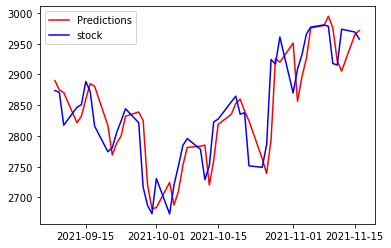

In [21]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

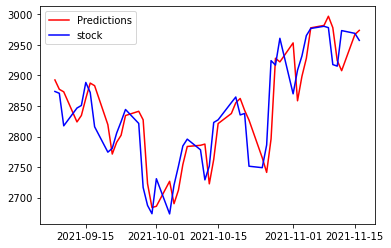

In [27]:
Y_test=Y_t.iloc[675:725]
Y_test=pd.DataFrame(Y_test)
predds_1=pd.DataFrame(predds_0, index=Y_test.index)
predds_1
plt.plot(predds_1, color='red',label="Predictions")
plt.plot(Y_test, color='blue',label="stock")
plt.legend()

In [23]:
print(Errors_A[0].mean())
print(Errors_B[0].mean())
print(Errors_C[0].mean())

1823.2939441880446
2657333.7868777183
1822.3405153977


In [24]:
print(Errors_A[1].mean())
print(Errors_B[1].mean())
print(Errors_C[1].mean())

32.7396376574767
1627.9566520578571
32.67127093999039


In [25]:
print(Errors_A[2].mean())
print(Errors_B[2].mean())
print(Errors_C[2].mean())

32.7396376574767
1627.9566520578571
32.67127093999039


In [26]:
print(Errors_A[3].mean())
print(Errors_B[3].mean())
print(Errors_C[3].mean())

1.158582182966735
57.303373483459715
1.1565559421468594
